<a href="https://colab.research.google.com/github/Ambrose2002/Ambrose2002.github.io/blob/main/DOA_Estimation_Accuracy_in_Simulation_and_Real_Data_(April_8th_2022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as scipysig
from scipy import stats
import time
from IPython.display import Audio
import librosa

In [ ]:
# defnie color cycles so that different methods have unique colors
colors = ["#c2a5cf", "#7b3294", "#fdb863", "#e66101", "#b8e186", "#4dac26"]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

In [ ]:
# DEFINE ALL GLOBAL PARAMETERS
num_azim = 360
num_alti = 0
wnc_param = 0.001

framerate = 48000
sound_speed = 343 # m/s
n_fft = 1024
nf = 214
highpass_filter = 200

bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])
capsule_distance = 0.015 # distance from capsule to center in meters

# Functions

#### Sound Simulation

In [ ]:
class SoundSource():
    r = []
    azim = []
    position = []
    signal = []
    signal_RMS = None

    def __init__(this, r, azim, amplitude, frequency, signal):
        this.frequency = frequency
        this.amplitude = amplitude
        this.r = r
        this.azim = azim
        this.signal = signal
        this.position = np.array([r * np.cos(azim), r * np.sin(azim), 0])
        this.signal_RMS = np.sqrt(np.mean(signal**2))

    def makeReflection(this, reflection_coefficient):
        reflection = this.copy()
        reflection.position = -reflection.position[2]
        reflection.signal = reflection.signal * reflection_coefficient
        return reflection

In [ ]:
class Capsule():
    axis = None
    position = None
    measurement = None
    name = None
    noise_RMS = None

    def __init__(self, name, direction, recording_length, axis_spacing = capsule_distance): #0.0147
        self.name = name
        self.axis = direction/np.linalg.norm(direction)
        self.position = np.zeros((3)) - axis_spacing * self.axis # need to verify this
        self.measurement = np.zeros(recording_length)

    def addReceivedSource(self, source, framerate, delay=0):
        # calculate travel time and distance
        travel_distance = np.linalg.norm(source.position - self.position)
        travel_time = 0.25 + travel_distance/sound_speed

        # attenuate signal based on travel distance
        attenuation = 1/travel_distance

        # NOTE: can correct attenuation coefficient to actually represent amplitude difference

        # finally, take dot product to apply capsule directionality and add it to capsule's overall received signal
        doa = source.position - self.position
        doa = doa/np.linalg.norm(doa)
        directionality_coeff = 0.5 + 0.5 * np.dot(self.axis, doa)

        # calculate overall received signal
        received_signal = attenuation * directionality_coeff * source.signal

        # add to the correct time in measured signal
        ind_start = int(framerate * (travel_time + delay))
        ind_end = np.min((ind_start + len(received_signal), len(self.measurement)))
        self.measurement[ind_start:ind_end] = self.measurement[ind_start:ind_end] + received_signal[0:(ind_end - ind_start)]

        # return the travel time
        return travel_time

    def addGaussianNoise(self, noise_sd):
        noise = np.random.normal(loc=0, scale=noise_sd, size=self.measurement.shape)
        self.noise_RMS = np.sqrt(np.mean(noise**2))
        self.measurement = self.measurement + noise

    def addBroadbandDirectionalNoise(self, noise_sd, azim):
        signal = np.random.normal(loc=0, scale=noise_sd, size=self.measurement.shape)
        noise = SoundSource(1, azim, 0.01, None, signal)
        self.addReceivedSource(noise, framerate=48000)

In [ ]:
def logTransform(spec, scale=10**(-5)):
    #return np.log(spec/np.max(spec) + scale * np.ones(spec.shape))
    return 20 * np.log10(spec + scale * np.ones(spec.shape))

In [ ]:
def samplePosition(n=1, radius=100):
    # in polar coordinates
    r = 20 #radius * np.sqrt(np.random.random(n))
    theta = np.random.random(n) * 2 * np.pi - np.pi # -np.pi/2
    return (r, theta)

In [ ]:
def generateSignal(r, azim, amplitude, frequency, framerate, length=0.5):
    # generate a sinusoid
    t = np.linspace(0, length, int(length * framerate)+1)
    dt = t[1] - t[0]
    t = t[:-1]

    # define an initial signal
    signal = np.zeros((1, len(t)))
    signal = amplitude * np.sin(2 * np.pi * t * frequency)

    # fade signal in and out
    fade_in = int(len(t)/10)
    signal[0:fade_in] = signal[0:fade_in] * np.linspace(0, 1, fade_in)**2
    signal[-fade_in:] = signal[-fade_in:] * np.linspace(1, 0, fade_in)**2

    # add to current sources
    return SoundSource(r, azim, amplitude, frequency, signal)

In [ ]:
def generateSignalsRandomLocation(amplitudes, frequencies, framerate = 48000):
    num_sources = len(amplitudes)
    all_sources = []

    for i in range(num_sources):
        # sample a position
        (r, azim) = samplePosition()

        # generate a sinusoid
        t = np.linspace(0, 1, framerate+1)
        dt = t[1] - t[0]
        t = t[:-1]

        # define an initial signal
        signal = np.zeros((1, len(t)))
        signal = amplitudes[i] * np.sin(2 * np.pi * t * frequencies[i])

        # fade signal in and out
        fade_in = int(len(t)/10)
        signal[0:fade_in] = signal[0:fade_in] * np.linspace(0, 1, fade_in)**2
        signal[-fade_in:] = signal[-fade_in:] * np.linspace(1, 0, fade_in)**2

        # add to current sources
        all_sources.append(SoundSource(r, azim, amplitudes[i], frequencies[i], signal))

    return all_sources

In [ ]:
def getSpectrograms(measurement, framerate, n_fft=1024, nf=200):
    specs = []
    for channel in measurement:
        freqs, inds, spec_complex = scipysig.stft(channel, fs=framerate, nperseg=n_fft)
        nf_full = spec_complex.shape[0]
        if (nf == None):
            nf = nf_full
        spec = spec_complex[0:nf, :]
        freqs = freqs[0:nf]
        specs.append(spec)

    return specs, freqs, inds

In [ ]:
def plotSingleAngle(ax, azims, estims_music_1, estims_music_2, estims_caim, estims_wcaim, true_angles, i, color_palette, SAVE_FILENAME=False):
    ax.plot(azims, estims_music_1[i]/np.max(estims_music_1[i]), label='MUSIC', color=color_palette[0])
    ax.plot(azims, estims_music_2[i]/np.max(estims_music_2[i]), label='MUSIC (all pixels)', color=color_palette[1])
    ax.plot(azims, estims_caim[i]/np.max(estims_caim[i]), label='CAIM', color=color_palette[2])
    ax.plot(azims, estims_wcaim[i]/np.max(estims_wcaim[i]), label='WCAIM', color=color_palette[3])
    for angle in true_angles:
        ax.plot([angle, angle], [-0.05, 1.05], 'k--')

    ax.set_xlabel('Azimuth (degrees)', fontsize=13)
    ax.set_ylabel('Normalized DOA Estimate', fontsize=13)
    ax.legend(loc='upper left', fontsize=12)
    ax.set_ylim([-0.1, 1.1])

#### Histogram-based DOA estimators

In [ ]:
class EmpiricalEstimator():
    def __init__(self):
        self.azimuth = None
        self.weights = None

    def calculateAzimuth(self, X):
        pass

    def scan(self, X, num_azim):
        # define azimuth angles to scan over
        azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
        azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

        # calculate azimuth angles (method differs for every algorithm)
        self.calculateAzimuth(X)

        # histogram all angles
        hist, _ = np.histogram(self.azimuth.ravel(), bins=azim_edges, weights=self.weights)
        return hist/np.max(hist)

In [ ]:
class WCAIM(EmpiricalEstimator):
    def calculateAzimuth(self, specs_B):
        self.azimuth = np.arctan2(np.real(specs_B[0].conj() * specs_B[2]),
                                  np.real(specs_B[0].conj() * specs_B[1]))
        self.weights = (np.abs(specs_B[0])**2).ravel()
        #self.weights = (np.abs(specs_B[0])).ravel() (for the future, this might work better for broadband calls)

#### Beamforming Functions

In [ ]:
def arrayResponseVector(azimuth, altitude, SCALE=np.sqrt(3)):
    A = np.array([SCALE, np.cos(azimuth) * np.cos(altitude), np.sin(azimuth) * np.cos(altitude), np.sin(altitude)]).T
    return A

In [ ]:
def getAngleVectors(num_azim, num_alti):
    azims_outer = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims_mid = azims_outer[0:-1] + (azims_outer[1] - azims_outer[0])/2

    if (num_alti == 0):
        return azims_mid, [0]
    else:
        altis_outer = np.linspace(-np.pi/2, np.pi/2, num_alti + 1)
        altis_mid = altis_outer[0:-1] + (altis_outer[1] - altis_outer[0])/2

    return azims_mid, altis_mid

In [ ]:
class Beamformer():
    def __init__(self):
        pass

    def beamformerWeightsAndOutput(self, A, X, params):
        pass

    def scan(self, num_azim, num_alti, X, params):
        # get discretized angle vectors
        azims, altis = getAngleVectors(num_azim, num_alti)

        # prepare matrices to store data
        output = np.zeros((len(azims), len(altis)))
        gain = np.zeros((len(azims), len(altis)))

        # scan over all azimuth and altitude angles
        for i in range(len(azims)):
            for j in range(len(altis)):
                # get the array response vector and the beamforming weights
                A = arrayResponseVector(azims[i], altis[j])
                w, y = self.beamformerWeightsAndOutput(A, X, params)

                # now calculate output and gain for this angle combination
                if (w is not None):
                    gain[i, j] = np.linalg.norm(w.conj().T @ A)

                output[i, j] = y

        # the output is empirically calculated based on the data
        output_azim = np.sum(output, axis=1)/np.sum(output)
        output_alti = np.sum(output, axis=0)/np.sum(output)

        # the gain is defined by weights and microphone architecture
        if (w is not None):
            gain_azim = np.sum(gain, axis=1)/np.sum(gain)
            gain_alti = np.sum(gain, axis=0)/np.sum(gain)
        else:
            gain_azim = np.zeros(len(azims))
            gain_azim = np.zeros(len(altis))

        return output_azim/np.max(output_azim), gain_azim

In [ ]:
class MUSIC(Beamformer):
    def beamformerWeightsAndOutput(self, A, X, params):
        # params are just the expected sources
        expected_sources = params[0]

        # calculate covariance
        covariance = X @ X.conj().T

        # calculate eigenvalues of covariance
        [eigvals, eigvecs] = np.linalg.eig(covariance)

        # make sure eigenvectors are ordered by the real part of the eigenvalues
        ordering = np.argsort(np.real(eigvals))[::-1]

        # get signal and noise eigenvalues
        signal_eigvecs = eigvecs[:, ordering[0:expected_sources]]
        noise_eigvecs = eigvecs[:, ordering[expected_sources:]]

        # look at the distance from noise eigenspace?
        y = 1/np.sqrt(np.abs(A.T @ noise_eigvecs @ noise_eigvecs.conj().T @ A))

        return None, y

In [ ]:
class WNC(Beamformer):
    def beamformerWeightsAndOutput(self, A, X, params):
        # params are the index before which there is no signal
        Xni = params[0]
        eps = params[1]

        # calculate covariance and inverse
        C = 1/X.shape[1] * Xni @ Xni.conj().T # verified that this is the same as (\sum_t X[:, t] * X[:, t].H)
        C_weighted = C + eps * np.eye(C.shape[0])
        Cinv = np.linalg.inv(C_weighted)

        # multiply and get beamformer weights
        CinvA = Cinv @ A
        w = CinvA/(A.conj().T @ CinvA)

        # get beamformer output (using the full X this timme)
        y = np.linalg.norm(w.conj().T @ X)

        return w, y

#### Evaluation Functions

In [ ]:
# angular error which accounts for rollover
def angleError(ang1, ang2):
    return np.abs(np.mod((ang1 - ang2 + np.pi), 2 * np.pi) - np.pi)

In [ ]:
# returns a dictionary with the azimuth values corresponding to the max of a DOA distribution (single source)
def getOutputMaxima(output):
    maxima = {}
    for key in output:
        maxima[key] = np.argmax(output[key])
    return maxima

In [ ]:
# returns a dictionary with the azimuth errors corresponding to the max of a DOA distribution (single source)
def getAngularError(maxima, azims, true_azimuth):
    error = {}
    for key in maxima:
        error[key] = angleError(azims[maxima[key]], true_azimuth)
    return error

In [ ]:
# --- methods to get angular maxima and errors when there are two sources ---

def getOutputMaximaAll(output, buffer=3):
    maxima = {}
    for key in output:
        maxima[key] = getBufferedMaxima(output[key], buffer=buffer)
    return maxima

def getBufferedMaxima(output, buffer=3):
    maxes = []
    output_temp = np.concatenate((output, output, output))
    for i in range(len(output)):
        if np.all(output_temp[len(output) + i] >= output_temp[(len(output) + i - buffer):(len(output) + i + buffer)]):
            maxes.append(i)

    # sort based on maximum values
    order = np.argsort(output[maxes])[::-1]

    # indices of maxima
    return np.array(maxes)[order]

def getAngularErrorTwoSource(maxima, azims, true_azimuths):
    error = {}
    for key in maxima:
        # get largest max
        angle0 = azims[maxima[key][0]]

        # get second largest max (or some value if no second max)
        if (len(maxima[key]) == 1):
            angle1 = angle0
        else:
            angle1 = azims[maxima[key][1]]

        option1 = angleError(angle0, true_azimuths[0]) + angleError(angle1, true_azimuths[1])
        option2 = angleError(angle1, true_azimuths[0]) + angleError(angle0, true_azimuths[1])
        error[key] = np.min((option1, option2))
        #print(key, ': num maxes is ', str(len(maxima[key])), ' -- angular error is ', str(np.round(error[key], 2)))

    return error

In [ ]:
# # testing the 1-source angular error function
# def testGetAngularError():
#     test = getAngularError({'a': 0.3}, -0.4)
#     assert (len(test) == 1) and (np.abs(test['a'] - 0.7) < 1e-5)

#     test = getAngularError({'a': 1.2}, 0.1)
#     assert (len(test) == 1) and (np.abs(test['a'] - 1.1) < 1e-5)

#     test = getAngularError({'a': 3}, -3)
#     assert (len(test) == 1) and (np.abs(test['a'] - (2 * np.pi - 6)) < 1e-5)

#     print('Passed tests!')

# # run tests
# testGetAngularError()

In [ ]:
# # testing the 1-source angular maxima function
# def testGetOutputMaxima():
#     test = getOutputMaxima({'a': [1, 2, 4]}, [-1, 0, 1])
#     assert (test == {'a': 1})

#     test = getOutputMaxima({'a': [1, 2, 4, 5, 1], 'b': [9, 0, -1, 8, 1]}, [-10, -9, -8, -7, -6])
#     assert (test == {'a': -7, 'b': -10})

#     print('Passed tests!')

# # run tests
# testGetOutputMaxima()

#### More functions

In [ ]:
def runAllMethods(s_B, specs_B, num_azim, num_alti, s_B_ni, specs_B_flat_ni, music_sources, wnc_param):
    specs_B_flat = np.array([np.ravel(spec) for spec in specs_B])

    # ---- WCAIM ---- #

    # time domain wcaim
    wcaim_time = WCAIM()
    output_wcaim_time = wcaim_time.scan(s_B, num_azim)

    # spec-domain wcaim
    wcaim = WCAIM()
    output_wcaim_tf = wcaim.scan(specs_B, num_azim)

    # ## --- WNC --- ##

    # time-domain WNC
    wnc = WNC()
    output_wnc_time, gain_wnc_time = wnc.scan(num_azim, num_alti, s_B, params=[s_B_ni, wnc_param])

    # time-frequency-domain WNC
    wnc = WNC()
    output_wnc_tf, gain_wnc_tf = wnc.scan(num_azim, num_alti, specs_B_flat, params=[specs_B_flat_ni, wnc_param])

    ## --- MUSIC --- ##

    # time-domain MUSIC
    music = MUSIC()
    output_music_time, gain_music_time = music.scan(num_azim, num_alti, s_B, params=[music_sources])

    # time-frequency-domain MUSIC
    music = MUSIC()
    output_music_tf, gain_music_tf = music.scan(num_azim, num_alti, specs_B_flat, params=[music_sources])

    ## --- put all results into dictionary?? --- ##
    output = {'WNC (time)': output_wnc_time,
              'WNC (t-f)': output_wnc_tf,
              'MUSIC (time)': output_music_time,
              'MUSIC (t-f)': output_music_tf,
              'AIM (time)': output_wcaim_time,
              'AIM (t-f)': output_wcaim_tf}

    return output

In [ ]:
def plotSpecs(ax, inds, freqs, spec, snr, freq):
    # plot received pressure spectrogram
    ax.pcolormesh(inds, freqs, logTransform(np.abs(spec)), linewidth=0, rasterized=True)
    ax.set_title('SNR: %d, Freq: %d' % (snr, freq), fontsize=16)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

In [ ]:
def plotOutput(ax, output, azims, snr, freq, true_azim):
    ax.grid(True, alpha=0.3)
    for method in output:
        ax.plot(180/np.pi * azims, output[method], label=method)

    if (not isinstance(true_azim, list)):
        ax.plot([180/np.pi * true_azim, 180/np.pi * true_azim], [0, 1], 'k--')
    else:
        ax.plot([180/np.pi * true_azim[0], 180/np.pi * true_azim[0]], [0, 1], 'k--')
        ax.plot([180/np.pi * true_azim[1], 180/np.pi * true_azim[1]], [0, 1], 'k--')

    #ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Signal Frequency (Hz)', fontsize=14)
    ax.set_ylabel('Angular Error (degrees)', fontsize=14)
    ax.set_title('SNR: %.3f, Freq: %.2f' % (snr, freq), fontsize=16)

# Simulation

#### Output for one signal

In [ ]:
## now try to repeat this, but with two sources
def experimentOneSignal(snr, frequency, true_azimuth):
    # microphone architecture specs
    axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
            'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
            'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
            'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

    bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

    # DOA estimation parameters
    azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    fig_specs, ax_specs = plt.subplots(1, 1, figsize=(6, 3))
    fig_output, ax_output = plt.subplots(2, 6, figsize=(20, 6))

    # randomly sample angles if not given by user
    if (true_azimuth == None):
        true_azimuth = [2 * np.pi * np.random.rand() - np.pi]

    # create a source
    sources = [generateSignal(1, true_azimuth, 1, frequency, framerate)]

    # create a new "microphone" (list of Capsule objects)
    microphone = [Capsule('FLU', axes['FLU'], recording_length = 2 * framerate),
                  Capsule('FRD', axes['FRD'], recording_length = 2 * framerate),
                  Capsule('BLD', axes['BLD'], recording_length = 2 * framerate),
                  Capsule('BRU', axes['BRU'], recording_length = 2 * framerate)]

    # calculate what the microphone capsules receive
    noise_ratio = sources[0].signal_RMS * 10**(-snr/20)
    print(noise_ratio)
    for capsule in microphone:
        capsule.addReceivedSource(sources[0], framerate)
        capsule.addGaussianNoise(noise_ratio)

    # get A-format time-domain signals and spectrogram
    measurements_A = np.array([capsule.measurement for capsule in microphone])
    specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

    # get B-format time-domain signals and spectrogram
    measurements_B = bformat_transform @ np.array(measurements_A)
    specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

    s_B_ni = measurements_B[:, 0:int(framerate/2)]
    specs_B_flat_ni = np.array([spec[0:47, :].ravel() for spec in specs_B])

    # run all current methods and return a huge output dictionary
    output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                            s_B_ni = s_B_ni,
                            specs_B_flat_ni = specs_B_flat_ni,
                            music_sources = 1,
                            wnc_param = wnc_param)

    # get maxima of angles corresponding to this output?
    maxima = getOutputMaxima(output)

    # get accuracy corresponding to this output?
    errors = getAngularError(maxima, azims, true_azimuth)

    for m, method in enumerate(output):
        ax_output[m % 2, m//2].plot(180/np.pi * azims, output[method])
        ax_output[m % 2, m//2].plot([180/np.pi * true_azimuth, 180/np.pi * true_azimuth], [0, 1], 'r--')
        ax_output[m % 2, m//2].set_title(method + ": error is " + str(int(np.round(180/np.pi * errors[method]))) + r"$^{\circ}$", fontsize=14)
        ax_output[m % 2, m//2].plot(180/np.pi * azims[maxima[method]], output[method][maxima[method]], 'k*')

    plotSpecs(ax_specs, inds, freqs, specs_B[0], snr, frequency)

    fig_output.tight_layout()
    fig_specs.tight_layout()

    #fig_output.savefig('one_source_example_output_snr_' + str(snr) + '.png', dpi=200)
    #fig_specs.savefig('one_source_example_spec_snr_' + str(snr) + '.png', dpi=200)

    capsule_rms = np.array([capsule.noise_RMS for capsule in microphone])
    noise_RMS = np.sqrt(np.mean(measurements_B[0,0:(framerate//4)]**2))

    print('Source A_rms = %.3f' % (2 * sources[0].signal_RMS))
    print('Noise RMS (based on first 0.25 sec) = %.3f' % noise_RMS)
    print('Approximate SNR = %.3f' % (20 * np.log10(2 * sources[0].signal_RMS/noise_RMS)))

    # return errors
    return output, maxima, errors

KeyboardInterrupt: ignored

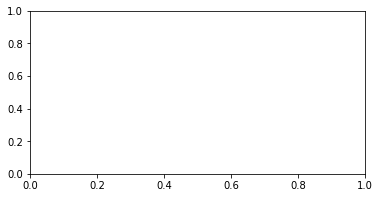

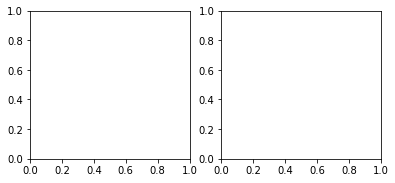

In [ ]:
for snr in [0, 10, 40]:
    output, maxima, errors = experimentOneSignal(snr=snr, frequency=1000, true_azimuth=np.pi/3)

In [ ]:
# microphone architecture specs
axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
        'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
        'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
        'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

# randomly sample angles if not given by user
true_azimuth = -1/3 * np.pi

# create a source
sources = [generateSignal(1, true_azimuth, 1, 3000, framerate)]

# create a new "microphone" (list of Capsule objects)
microphone = [Capsule('FLU', axes['FLU'], recording_length = framerate),
              Capsule('FRD', axes['FRD'], recording_length = framerate),
              Capsule('BLD', axes['BLD'], recording_length = framerate),
              Capsule('BRU', axes['BRU'], recording_length = framerate)]

# calculate what the microphone capsules receive
snr = 20
noise_ratio = sources[0].signal_RMS * 10**(-snr/20)

for capsule in microphone:
    capsule.addReceivedSource(sources[0], framerate)
    capsule.addGaussianNoise(noise_ratio)

# get A-format time-domain signals and spectrogram
measurements_A = np.array([capsule.measurement for capsule in microphone])
specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=nf)

# get B-format time-domain signals and spectrogram
measurements_B = bformat_transform @ np.array(measurements_A)
specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=nf)

s_B_ni = measurements_B[:, 0:int(framerate/5)]
specs_B_flat_ni = np.array([spec[0:20, :].ravel() for spec in specs_B])

# run all current methods and return a huge output dictionary
output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                        s_B_ni = s_B_ni,
                        specs_B_flat_ni = specs_B_flat_ni,
                        music_sources = 1,
                        wnc_param = wnc_param)

In [ ]:
SAVEFIG = '_05_11_2022'

In [ ]:
SAVEFIG = False

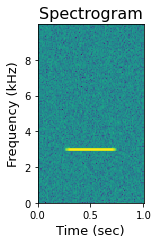

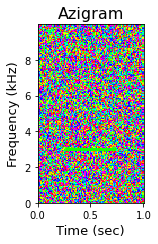

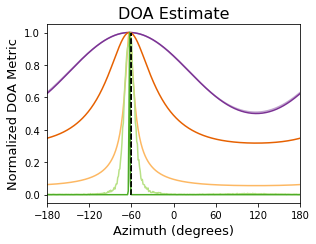

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
plt.pcolormesh(inds, freqs/1000, logTransform(np.abs(specs_B[0])), linewidth=0, rasterized=True)
#plt.pcolormesh(inds, freqs/1000, 20 * np.log10(np.abs(specs_B[0])))
ax.set_title('Spectrogram', fontsize=16)
#ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
ax.set_xlabel('Time (sec)', fontsize=13)
ax.set_ylabel('Frequency (kHz)', fontsize=13)
#plt.colorbar()
fig.tight_layout()
if (SAVEFIG):
        fig.savefig('one_source_example_sim_spec' + SAVEFIG + '.png', dpi=200)
        fig.savefig('one_source_example_sim_spec' + SAVEFIG + '.pdf', dpi=200)

wcaim = WCAIM()
wcaim.scan(specs_B, num_azim)

fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
plt.pcolormesh(inds, freqs/1000, wcaim.azimuth * 180/np.pi, cmap='hsv', vmin=-180, vmax=180, linewidth=0, rasterized=True)
ax.set_title('Azigram', fontsize=16)
#ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
ax.set_xlabel('Time (sec)', fontsize=13)
ax.set_ylabel('Frequency (kHz)', fontsize=13)
#plt.colorbar(ticks = [-180, -120, -60, 0, 60, 120, 180])
fig.tight_layout()
if (SAVEFIG):
        fig.savefig('one_source_example_sim_azim' + SAVEFIG + '.png', dpi=200)
        fig.savefig('one_source_example_sim_azim' + SAVEFIG + '.pdf', dpi=200)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
for method in output:
    ax.plot(180/np.pi * azims, output[method], label=method)
    ax.plot([180/np.pi * true_azimuth, 180/np.pi * true_azimuth], [0, 1], 'k--')
    #ax_output.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Azimuth (degrees)', fontsize=13)
    ax.set_ylabel('Normalized DOA Metric', fontsize=13)
    ax.set_title('DOA Estimate', fontsize=16)
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
    ax.set_xlim([-180, 180])

#ax.legend(loc='upper left', fontsize=12)
fig.tight_layout()
if (SAVEFIG):
        fig.savefig('one_source_example_sim_dist' + SAVEFIG + '.png', dpi=200)
        fig.savefig('one_source_example_sim_dist' + SAVEFIG + '.pdf', dpi=200)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.8, 3.5))
plt.pcolormesh(inds, freqs/1000, wcaim.azimuth * 180/np.pi, cmap='hsv', vmin=-180, vmax=180, linewidth=0, rasterized=True)
ax.set_title('Azimuth', fontsize=16)
#ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
#ax.set_xlabel('Time (sec)', fontsize=13)
ax.set_ylabel('Frequency (kHz)', fontsize=13)
plt.colorbar(ticks = [-180, -120, -60, 0, 60, 120, 180], orientation='horizontal')
fig.tight_layout()
if (0):
        fig.savefig('azigram_colorbar.png', dpi=200)
        fig.savefig('azigram_colorbar.pdf', dpi=200)


#### Output for two signals

In [ ]:
## now try to repeat this, but with two sources
def experimentTwoSignals(snr, frequency, true_azimuths, overlap):
    # microphone architecture specs
    axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
            'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
            'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
            'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

    bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

    # signal and FFT parameters
    recording_length = 3 * framerate

    # DOA estimation parameters
    azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    fig_specs, ax_specs = plt.subplots(1, 1, figsize=(6, 3))
    fig_output, ax_output = plt.subplots(2, 6, figsize=(20, 6))

    # randomly sample angles if not given by user
    if (true_azimuths == None):
        true_azimuths = [2 * np.pi * np.random.rand() - np.pi,
                          2 * np.pi * np.random.rand() - np.pi]

    # create a source
    sources = [generateSignal(1, true_azimuths[0], 1, frequency, framerate),
                generateSignal(1, true_azimuths[1], 1, frequency, framerate)]

    # create a new "microphone" (list of Capsule objects)
    microphone = [Capsule('FLU', axes['FLU'], recording_length),
                  Capsule('FRD', axes['FRD'], recording_length),
                  Capsule('BLD', axes['BLD'], recording_length),
                  Capsule('BRU', axes['BRU'], recording_length)]

    # calculate what the microphone capsules receive
    noise_ratio = sources[0].signal_RMS * 10**(-snr/20)
    for capsule in microphone:
        capsule.addReceivedSource(sources[0], framerate)
        capsule.addReceivedSource(sources[1], framerate, delay = 1 - overlap)
        capsule.addGaussianNoise(noise_ratio)

    # get A-format time-domain signals and spectrogram
    measurements_A = np.array([capsule.measurement for capsule in microphone])
    specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

    # get B-format time-domain signals and spectrogram
    measurements_B = bformat_transform @ np.array(measurements_A)
    specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

    s_B_ni = measurements_B[:, 0:int(framerate/5)]
    specs_B_flat_ni = np.array([spec[0:20, :].ravel() for spec in specs_B])

    # run all current methods and return a huge output dictionary
    output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                            s_B_ni = s_B_ni,
                            specs_B_flat_ni = specs_B_flat_ni,
                            music_sources = 2)

    # get maxima of angles corresponding to this output?
    maxima = getOutputMaximaAll(output)

    # get accuracy corresponding to this output?
    errors = getAngularErrorTwoSource(maxima, azims, true_azimuths)

    for m, method in enumerate(output):
        ax_output[m % 2, m//2].plot(180/np.pi * azims, output[method])
        ax_output[m % 2, m//2].plot([180/np.pi * true_azimuths[0], 180/np.pi * true_azimuths[0]], [0, 1], 'r--')
        ax_output[m % 2, m//2].plot([180/np.pi * true_azimuths[1], 180/np.pi * true_azimuths[1]], [0, 1], 'r--')
        ax_output[m % 2, m//2].set_title(method + ": " + str(int(np.round(180/np.pi * errors[method]))) + r"$^{\circ}$", fontsize=14)
        ax_output[m % 2, m//2].plot(180/np.pi * azims[maxima[method]], output[method][maxima[method]], 'k*')

    plotSpecs(ax_specs, inds, freqs, specs_B[0], snr, frequency)

    fig_output.tight_layout()
    fig_specs.tight_layout()

    #fig_output.savefig('two_source_example_output_snr_' + str(snr) + '_overlap_' + str(overlap) + '.png', dpi=200)
    #fig_specs.savefig('two_source_example_spec_snr_' + str(snr) + '_overlap_' + str(overlap) + '.png', dpi=200)

    capsule_rms = np.array([capsule.noise_RMS for capsule in microphone])
    noise_RMS = np.sqrt(np.mean(measurements_B[0,0:(framerate//4)]**2))

    print('Source A_rms = %.3f' % (2 * sources[0].signal_RMS))
    print('Noise RMS (based on first 0.25 sec) = %.3f' % noise_RMS)
    print('Approximate SNR = %.3f' % (20 * np.log10(2 * sources[0].signal_RMS/noise_RMS)))

    # return errors
    return output, maxima, errors

In [ ]:
output, maxima, errors = experimentTwoSignals(snr=20, frequency=5000, true_azimuths = [0, np.pi/6], overlap=0)

In [ ]:
# microphone architecture specs
axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
        'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
        'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
        'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

# DOA estimation parameters
azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

# randomly sample angles if not given by user
true_azimuths = [0, np.pi/4]

# create a source
sources = [generateSignal(1, true_azimuths[0], 1, 2000, framerate),
           generateSignal(1, true_azimuths[1], 1, 4000, framerate)]

# create a new "microphone" (list of Capsule objects)
microphone = [Capsule('FLU', axes['FLU'], recording_length = int(1.5 * framerate)),
              Capsule('FRD', axes['FRD'], recording_length = int(1.5 * framerate)),
              Capsule('BLD', axes['BLD'], recording_length = int(1.5 * framerate)),
              Capsule('BRU', axes['BRU'], recording_length = int(1.5 * framerate))]

# calculate what the microphone capsules receive
snr = 20
noise_ratio = sources[0].signal_RMS * 10**(-snr/20)

for capsule in microphone:
    capsule.addReceivedSource(sources[0], framerate)
    capsule.addReceivedSource(sources[1], framerate, delay = 0.5)
    capsule.addGaussianNoise(noise_ratio)

# get A-format time-domain signals and spectrogram
measurements_A = np.array([capsule.measurement for capsule in microphone])
specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=nf)

# get B-format time-domain signals and spectrogram
measurements_B = bformat_transform @ np.array(measurements_A)
specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=nf)

s_B_ni = measurements_B[:, 0:int(framerate/5)]
specs_B_flat_ni = np.array([spec[0:20, :].ravel() for spec in specs_B])

# run all current methods and return a huge output dictionary
output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                        s_B_ni = s_B_ni,
                        specs_B_flat_ni = specs_B_flat_ni,
                        music_sources = 2,
                        wnc_param = wnc_param)

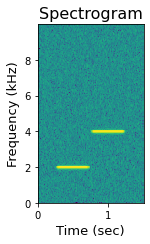

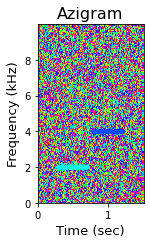

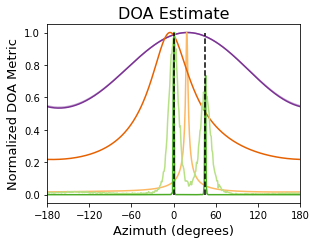

In [ ]:
SAVEFIG = '_05_11_2022'

fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
plt.pcolormesh(inds, freqs/1000, logTransform(np.abs(specs_B[0])), linewidth=0, rasterized=True)
ax.set_title('Spectrogram', fontsize=16)
#ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
ax.set_xlabel('Time (sec)', fontsize=13)
ax.set_ylabel('Frequency (kHz)', fontsize=13)
#plt.colorbar()
fig.tight_layout()
if (SAVEFIG):
        fig.savefig('two_source_example_sim_spec' + SAVEFIG + '.png', dpi=200)
        fig.savefig('two_source_example_sim_spec' + SAVEFIG + '.pdf', dpi=200)

wcaim = WCAIM()
wcaim.scan(specs_B, num_azim)

fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
plt.pcolormesh(inds, freqs/1000, wcaim.azimuth * 180/np.pi, cmap='hsv', vmin=-180, vmax=180, linewidth=0, rasterized=True)
ax.set_title('Azigram', fontsize=16)
#ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
ax.set_xlabel('Time (sec)', fontsize=13)
ax.set_ylabel('Frequency (kHz)', fontsize=13)
#plt.colorbar(ticks = [-180, 0, 180])
fig.tight_layout()
if (SAVEFIG):
        fig.savefig('two_source_example_sim_azim' + SAVEFIG + '.png', dpi=200)
        fig.savefig('two_source_example_sim_azim' + SAVEFIG + '.pdf', dpi=200)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
for method in output:
    ax.plot(180/np.pi * azims, output[method], label=method)
    #ax_output.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Azimuth (degrees)', fontsize=13)
    ax.set_ylabel('Normalized DOA Metric', fontsize=13)
    ax.set_title('DOA Estimate', fontsize=16)
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
    ax.set_xlim([-180, 180])

ax.plot([180/np.pi * true_azimuths[0], 180/np.pi * true_azimuths[0]], [0, 1], 'k--')
ax.plot([180/np.pi * true_azimuths[1], 180/np.pi * true_azimuths[1]], [0, 1], 'k--')

fig.tight_layout()
if (SAVEFIG):
        fig.savefig('two_source_example_sim_dist' + SAVEFIG + '.png', dpi=200)
        fig.savefig('two_source_example_sim_dist' + SAVEFIG + '.pdf', dpi=200)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for method in output:
    ax.plot(180/np.pi * azims, output[method], label=method)
    #ax_output.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Azimuth (degrees)', fontsize=13)
    ax.set_ylabel('Normalized DOA Metric', fontsize=13)
    #ax.set_title('Simulation: Two Sources', fontsize=16)
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
    ax.set_xlim([-180, 180])

ax.plot([180/np.pi * true_azimuths[0], 180/np.pi * true_azimuths[0]], [0, 1], 'k--')
ax.plot([180/np.pi * true_azimuths[1], 180/np.pi * true_azimuths[1]], [0, 1], 'k--')
ax.legend(ncol = 3, bbox_to_anchor=(0, 1), loc='lower left', fontsize=12)

fig.tight_layout()
fig.savefig('legend_horizontal.png', dpi=200)
fig.savefig('legend_horizontal.pdf', dpi=200)

#### Output for one signal with random frequency/azimuth

In [ ]:
def experimentOneSignalRandom(num_trials, snr = 20):
    # microphone architecture specs
    axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
            'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
            'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
            'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

    bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

    # azimuth vector
    azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    overall_errors = {}

    # do multiple trials
    for trial in range(num_trials):
        print(trial, end=', ')

        # randomly sample angle
        frequency = 5000 * np.random.rand()
        true_azimuth = 2 * np.pi * np.random.rand() - np.pi

        # create a source
        source = generateSignal(1, true_azimuth, 1, frequency, framerate)

        # create a new "microphone" (list of Capsule objects)
        microphone = [Capsule('FLU', axes['FLU'], recording_length = framerate),
                      Capsule('FRD', axes['FRD'], recording_length = framerate),
                      Capsule('BLD', axes['BLD'], recording_length = framerate),
                      Capsule('BRU', axes['BRU'], recording_length = framerate)]

        # calculate what the microphone capsules receive
        noise_ratio = source.signal_RMS * 10**(-snr/20)
        for capsule in microphone:
            capsule.addReceivedSource(source, framerate)
            capsule.addGaussianNoise(noise_ratio)

        # get A-format time-domain signals and spectrogram
        measurements_A = np.array([capsule.measurement for capsule in microphone])
        specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

        # get B-format time-domain signals and spectrogram
        measurements_B = bformat_transform @ np.array(measurements_A)
        specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

        s_B_ni = measurements_B[:, 0:int(framerate/5)]
        specs_B_flat_ni = np.array([spec[0:20, :].ravel() for spec in specs_B])

        # run all current methods and return a huge output dictionary
        output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                                s_B_ni = s_B_ni,
                                specs_B_flat_ni = specs_B_flat_ni,
                                music_sources = 1,
                                wnc_param = wnc_param)

        # get maxima of angles corresponding to this output?
        maxima = getOutputMaxima(output)

        # get accuracy corresponding to this output?
        errors = getAngularError(maxima, azims, true_azimuth)

        # if the dictionary doesn't exist yet, initialize it
        if (len(overall_errors) == 0):
            for key in errors:
                overall_errors[key] = np.zeros((num_trials))

        # place angular error in correct place in main output dictionary
        for key in errors:
            overall_errors[key][trial] = errors[key]

    return overall_errors

In [ ]:
overall_errors = experimentOneSignalRandom(num_trials = 20)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

In [ ]:
overall_errors

{'AIM (t-f)': array([0.00747832, 0.01850753, 0.09947602, 0.00331599, 0.06167636,
        0.11110465, 0.0282498 , 0.00672295, 0.00317806, 0.05552713,
        0.03074494, 0.00430849, 0.00383038, 0.11381116, 0.06074777,
        0.0048647 , 0.03601178, 0.005101  , 0.05768458, 0.0441925 ]),
 'AIM (time)': array([0.00997497, 0.00105424, 0.06456943, 0.00331599, 0.02676978,
        0.14601123, 0.0282498 , 0.02417625, 0.00317806, 0.09043372,
        0.04819823, 0.02176178, 0.02128367, 0.09635787, 0.07820106,
        0.01258859, 0.07091837, 0.01235229, 0.00532471, 0.06164579]),
 'MUSIC (t-f)': array([0.00747832, 0.01850753, 0.08202273, 0.02076928, 0.02676978,
        0.12855794, 0.0282498 , 0.00672295, 0.00317806, 0.05552713,
        0.04819823, 0.00430849, 0.00383038, 0.13126446, 0.06074777,
        0.0048647 , 0.03601178, 0.005101  , 0.04023129, 0.0441925 ]),
 'MUSIC (time)': array([0.00747832, 0.01850753, 0.08202273, 0.02076928, 0.02676978,
        0.12855794, 0.0282498 , 0.00672295, 0.003178

In [ ]:
print('-----------------------------------------------------------------------------')
print('Errors (in degrees) for a single source, relative to the 0 degree measurement')
print('-----------------------------------------------------------------------------')
for method in overall_errors:
    print('%s -- $%.1f\degree \pm %.1f\degree$' % (method, 180/np.pi * np.mean(overall_errors[method]), 180/np.pi * np.std(overall_errors[method])))

-----------------------------------------------------------------------------
Errors (in degrees) for a single source, relative to the 0 degree measurement
-----------------------------------------------------------------------------
WNC (time) -- $2.2\degree \pm 2.3\degree$
WNC (t-f) -- $2.2\degree \pm 2.2\degree$
MUSIC (time) -- $2.2\degree \pm 2.2\degree$
MUSIC (t-f) -- $2.2\degree \pm 2.2\degree$
AIM (time) -- $2.4\degree \pm 2.2\degree$
AIM (t-f) -- $2.2\degree \pm 2.1\degree$


#### Output for one signal across frequency

In [ ]:
def experimentOneSignalAcrossFrequencies(snrs, frequencies, num_trials):
    # microphone architecture specs
    axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
            'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
            'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
            'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

    bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

    azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    overall_errors = {}

    fig_output, ax_output = plt.subplots(len(snrs), len(frequencies), figsize=(4 * len(frequencies), 4 * len(snrs)))
    fig_specs, ax_specs = plt.subplots(len(snrs), len(frequencies), figsize=(4 * len(frequencies), 4 * len(snrs)))

    # noise ratios
    for n in range(len(snrs)):
        print('---------------------')
        print('SNR: ', snrs[n])

        # frequencies
        for f in range(len(frequencies)):
            print('\t Frequency: ', frequencies[f])
            print('\t\t Trial ', end='')

            # do multiple trials
            for trial in range(num_trials):
                print(trial, end=', ')

                # randomly sammple angle
                true_azimuth = 2 * np.pi * np.random.rand() - np.pi

                # create a source
                source = generateSignal(1, true_azimuth, 1, frequencies[f], framerate)

                # create a new "microphone" (list of Capsule objects)
                microphone = [Capsule('FLU', axes['FLU'], recording_length = framerate),
                              Capsule('FRD', axes['FRD'], recording_length = framerate),
                              Capsule('BLD', axes['BLD'], recording_length = framerate),
                              Capsule('BRU', axes['BRU'], recording_length = framerate)]

                # calculate what the microphone capsules receive
                noise_ratio = source.signal_RMS * 10**(-snrs[n]/20)
                for capsule in microphone:
                    capsule.addReceivedSource(source, framerate)
                    capsule.addGaussianNoise(noise_ratio)

                # get A-format time-domain signals and spectrogram
                measurements_A = np.array([capsule.measurement for capsule in microphone])
                specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

                # get B-format time-domain signals and spectrogram
                measurements_B = bformat_transform @ np.array(measurements_A)
                specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

                s_B_ni = measurements_B[:, 0:int(framerate/5)]
                specs_B_flat_ni = np.array([spec[0:20, :].ravel() for spec in specs_B])

                # run all current methods and return a huge output dictionary
                output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                                       s_B_ni = s_B_ni,
                                       specs_B_flat_ni = specs_B_flat_ni,
                                       music_sources = 1)

                if (trial == 0):
                    plotOutput(ax_output[n, f], output, azims, snrs[n], frequencies[f], true_azimuth)
                    plotSpecs(ax_specs[n, f], inds, freqs, specs_B[0], snrs[n], frequencies[f])

                # get maxima of angles corresponding to this output?
                maxima = getOutputMaxima(output)

                # get accuracy corresponding to this output?
                errors = getAngularError(maxima, azims, true_azimuth)

                # if the dictionary doesn't exist yet, initialize it
                if (len(overall_errors) == 0):
                    for key in errors:
                        overall_errors[key] = np.zeros((len(snrs), len(frequencies), num_trials))

                # place angular error in correct place in main output dictionary
                for key in errors:
                    overall_errors[key][n, f, trial] = errors[key]

            print('\n')

    # return errors
    fig_specs.tight_layout()
    fig_output.tight_layout()

    #fig_output.savefig('one_source_sweep_output.png', dpi=200)
    #fig_specs.savefig('one_source_sweep_specs.png', dpi=200)

    return overall_errors

In [ ]:
inds[0:20]

In [ ]:
def experimentOneSignalAcrossFrequenciesAndAzimuths(frequencies, azimuths, num_trials, snr):
    # microphone architecture specs
    axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
            'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
            'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
            'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

    bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

    # signal and FFT parameters
    azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    overall_errors = {}

    fig_output, ax_output = None, None #plt.subplots(len(azimuths), len(frequencies), figsize=(4 * len(frequencies), 4 * len(azimuths)))
    fig_specs, ax_specs = None, None # plt.subplots(len(azimuths), len(frequencies), figsize=(4 * len(frequencies), 4 * len(azimuths)))

    # noise ratios
    for n in range(len(azimuths)):
        print('---------------------')
        print('Azimuth: ', azimuths[n])

        # frequencies
        for f in range(len(frequencies)):
            print('\t Frequency: ', frequencies[f])
            print('\t\t Trial ', end='')

            # do multiple trials
            for trial in range(num_trials):
                print(trial, end=', ')

                # randomly sammple angle
                #true_azimuth = 2 * np.pi * np.random.rand() - np.pi

                # create a source
                source = generateSignal(1, azimuths[n], 1, frequencies[f], framerate)

                # create a new "microphone" (list of Capsule objects)
                microphone = [Capsule('FLU', axes['FLU'], recording_length = framerate),
                              Capsule('FRD', axes['FRD'], recording_length = framerate),
                              Capsule('BLD', axes['BLD'], recording_length = framerate),
                              Capsule('BRU', axes['BRU'], recording_length = framerate)]

                # calculate what the microphone capsules receive
                noise_ratio = source.signal_RMS * 10**(-snr/20)
                for capsule in microphone:
                    capsule.addReceivedSource(source, framerate)
                    capsule.addGaussianNoise(noise_ratio)

                # get A-format time-domain signals and spectrogram
                measurements_A = np.array([capsule.measurement for capsule in microphone])
                specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

                # get B-format time-domain signals and spectrogram
                measurements_B = bformat_transform @ np.array(measurements_A)
                specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

                s_B_ni = measurements_B[:, 0:int(framerate/5)]
                specs_B_flat_ni = np.array([spec[0:47, :].ravel() for spec in specs_B])

                # run all current methods and return a huge output dictionary
                output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                                       s_B_ni = s_B_ni,
                                       specs_B_flat_ni = specs_B_flat_ni,
                                       music_sources = 1)

                #if (trial == 0):
                #    plotOutput(ax_output[n, f], output, azims, snr, frequencies[f], azimuths[n])
                #    plotSpecs(ax_specs[n, f], inds, freqs, specs_B[0], snr, frequencies[f])

                # get maxima of angles corresponding to this output?
                maxima = getOutputMaxima(output)

                # get accuracy corresponding to this output?
                errors = getAngularError(maxima, azims, azimuths[n])

                # if the dictionary doesn't exist yet, initialize it
                if (len(overall_errors) == 0):
                    for key in errors:
                        overall_errors[key] = np.zeros((len(azimuths), len(frequencies), num_trials))

                # place angular error in correct place in main output dictionary
                for key in errors:
                    overall_errors[key][n, f, trial] = errors[key]

            print('\n')

    # return errors
    #fig_specs.tight_layout()
    #fig_output.tight_layout()

    #fig_output.savefig('one_source_sweep_output.png', dpi=200)
    #fig_specs.savefig('one_source_sweep_specs.png', dpi=200)

    return overall_errors

In [ ]:
def experimentOneSignalAcrossFrequenciesAndAzimuthsAIM(frequencies, azimuths, num_trials, snr):
    # microphone architecture specs
    axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
            'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
            'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
            'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

    bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

    # signal and FFT parameters
    azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    overall_errors = None

    fig_output, ax_output = None, None #plt.subplots(len(azimuths), len(frequencies), figsize=(4 * len(frequencies), 4 * len(azimuths)))
    fig_specs, ax_specs = None, None # plt.subplots(len(azimuths), len(frequencies), figsize=(4 * len(frequencies), 4 * len(azimuths)))

    # noise ratios
    for n in range(len(azimuths)):
        print('---------------------')
        print('Azimuth: ', azimuths[n])

        # frequencies
        for f in range(len(frequencies)):
            print('\t Frequency: ', frequencies[f])
            print('\t\t Trial ', end='')

            # do multiple trials
            for trial in range(num_trials):
                print(trial, end=', ')

                # randomly sammple angle
                #true_azimuth = 2 * np.pi * np.random.rand() - np.pi

                # create a source
                source = generateSignal(1, azimuths[n], 1, frequencies[f], framerate)

                # create a new "microphone" (list of Capsule objects)
                microphone = [Capsule('FLU', axes['FLU'], recording_length = framerate),
                              Capsule('FRD', axes['FRD'], recording_length = framerate),
                              Capsule('BLD', axes['BLD'], recording_length = framerate),
                              Capsule('BRU', axes['BRU'], recording_length = framerate)]

                # calculate what the microphone capsules receive
                noise_ratio = source.signal_RMS * 10**(-snr/20)
                for capsule in microphone:
                    capsule.addReceivedSource(source, framerate)
                    capsule.addGaussianNoise(noise_ratio)

                # get A-format time-domain signals and spectrogram
                measurements_A = np.array([capsule.measurement for capsule in microphone])
                specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

                # get B-format time-domain signals and spectrogram
                measurements_B = bformat_transform @ np.array(measurements_A)
                specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

                # run all current methods and return a huge output dictionary
                wcaim = WCAIM()
                output_wcaim_tf = wcaim.scan(specs_B, num_azim)

                # get maxima of angles corresponding to this output?
                maxima = np.argmax(output_wcaim_tf)

                # get accuracy corresponding to this output?
                error = angleError(azims[maxima], azimuths[n])

                # if the dictionary doesn't exist yet, initialize it
                if (overall_errors is None):
                    overall_errors = np.zeros((len(azimuths), len(frequencies), num_trials))

                # place angular error in correct place in main output dictionary
                overall_errors[n, f, trial] = error

            print('\n')

    # return errors
    #fig_specs.tight_layout()
    #fig_output.tight_layout()

    #fig_output.savefig('one_source_sweep_output.png', dpi=200)
    #fig_specs.savefig('one_source_sweep_specs.png', dpi=200)

    return overall_errors

In [ ]:
num_azim

360

In [ ]:
azimuths = np.linspace(-np.pi, np.pi, 90)
frequencies = np.linspace(1000, 10000, 20)
num_trials = 1
snr = 60

overall_errors = experimentOneSignalAcrossFrequenciesAndAzimuthsAIM(frequencies, azimuths, num_trials, snr)

Streaming output truncated to the last 5000 lines.

	 Frequency:  4315.78947368421
		 Trial 0, 

	 Frequency:  4789.473684210527
		 Trial 0, 

	 Frequency:  5263.157894736842
		 Trial 0, 

	 Frequency:  5736.8421052631575
		 Trial 0, 

	 Frequency:  6210.526315789473
		 Trial 0, 

	 Frequency:  6684.210526315789
		 Trial 0, 

	 Frequency:  7157.894736842105
		 Trial 0, 

	 Frequency:  7631.578947368421
		 Trial 0, 

	 Frequency:  8105.263157894737
		 Trial 0, 

	 Frequency:  8578.947368421053
		 Trial 0, 

	 Frequency:  9052.631578947368
		 Trial 0, 

	 Frequency:  9526.315789473683
		 Trial 0, 

	 Frequency:  10000.0
		 Trial 0, 

---------------------
Azimuth:  -2.4356167763786036
	 Frequency:  1000.0
		 Trial 0, 

	 Frequency:  1473.6842105263158
		 Trial 0, 

	 Frequency:  1947.3684210526317
		 Trial 0, 

	 Frequency:  2421.0526315789475
		 Trial 0, 

	 Frequency:  2894.7368421052633
		 Trial 0, 

	 Frequency:  3368.4210526315787
		 Trial 0, 

	 Frequency:  3842.1052631578946
		 Tr

In [ ]:
import matplotlib as mpl

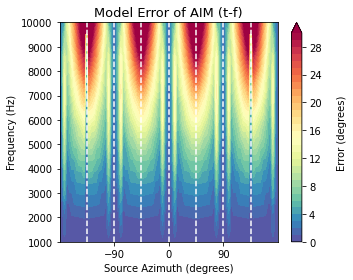

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
method_mean = 180/np.pi * np.mean(overall_errors[:,:,:], axis=2)
contf = ax.contourf(180/np.pi * azimuths, frequencies, method_mean.T,
                    levels = np.linspace(0, 30, 31), cmap='Spectral_r', extend='max')
ax.set_title('Model Error of AIM (t-f)', fontsize=13)
ax.set_xticks([-90, 0, 90])

for ang in [-135, -90, -45, 0, 45, 90, 135]:
    ax.plot([ang, ang], [frequencies[0], frequencies[-1]], 'w--')

ax.set_xlabel('Source Azimuth (degrees)', fontsize=10)
ax.set_ylabel('Frequency (Hz)', fontsize=10)

cbar = plt.colorbar(contf)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Error (degrees)', fontsize=10, rotation=90)
fig.tight_layout()

fig.savefig('frequency_azimuth_errors_aim_015.png', dpi=200)
fig.savefig('frequency_azimuth_errors_aim_015.pdf', dpi=200)


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for m, method in enumerate(overall_errors):
    #plt.subplot(2, 3, m+1)
    method_mean = 180/np.pi * np.mean(overall_errors[method][:,:,:], axis=2)
    contf = ax[m % 2, m//2].contourf(180/np.pi * azimuths, frequencies, method_mean.T, levels = np.linspace(0, 20, 11), cmap='RdYlGn_r')
    ax[m % 2, m//2].set_title(method, fontsize=16)
    ax[m % 2, m//2].set_xticks([-90, 0, 90])

    for ang in [-135, -90, -45, 0, 45, 90, 135]:
        ax[m % 2, m//2].plot([ang, ang], [frequencies[0], frequencies[-1]], 'w--')

    if (m % 2 == 0):
        ax[m % 2, m//2].get_xaxis().set_visible(False)
    else:
        ax[m % 2, m//2].set_xlabel('Source Azimuth (degrees)', fontsize=12)

    if (m//2 > 0):
        ax[m % 2, m//2].get_yaxis().set_visible(False)
    else:
        ax[m % 2, m//2].set_ylabel('Frequency (Hz)', fontsize=12)

    #plt.colorbar(contf)

fig.tight_layout()
fig.savefig('frequency_azimuth_errors.png', dpi=200)
fig.savefig('frequency_azimuth_errors.pdf', dpi=200)

#for ang in [-135, -90, -45, 0, 45, 90, 135]:
#   ax[m % 2, m//2].plot([ang, ang], [frequencies[0], frequencies[-1]], 'w--')


In [ ]:
plt.figure(figsize=(4, 4))
method_mean = 180/np.pi * np.mean(overall_errors['WCAIM (t-f)'][:,:,:], axis=2)
contf = ax[m % 2, m//2].contourf(180/np.pi * azimuths, frequencies, method_mean.T, levels = np.linspace(0, 20, 11), cmap='RdYlGn_r')
plt.colorbar(contf)

plt.tight_layout()
plt.savefig('frequency_azimuth_colorbar.png', dpi=200)

#for ang in [-135, -90, -45, 0, 45, 90, 135]:
#   ax[m % 2, m//2].plot([ang, ang], [frequencies[0], frequencies[-1]], 'w--')


In [ ]:
# microphone architecture specs
axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
        'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
        'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
        'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

# create a source
source = generateSignal(1, np.pi/2, 1, 5000, framerate)

# create a new "microphone" (list of Capsule objects)
microphone = [Capsule('FLU', axes['FLU'], recording_length = 2 * framerate),
              Capsule('FRD', axes['FRD'], recording_length = 2 * framerate),
              Capsule('BLD', axes['BLD'], recording_length = 2 * framerate),
              Capsule('BRU', axes['BRU'], recording_length = 2 * framerate)]

# calculate what the microphone capsules receive
noise_ratio = source.signal_RMS * 10**(-snr/20)
for capsule in microphone:
    capsule.addReceivedSource(source, framerate)
    capsule.addGaussianNoise(noise_ratio)

# get A-format time-domain signals and spectrogram
measurements_A = np.array([capsule.measurement for capsule in microphone])
specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

# get B-format time-domain signals and spectrogram
measurements_B = bformat_transform @ np.array(measurements_A)
specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

In [ ]:
# plot received pressure spectrogram
fig, ax = plt.subplots(1, 1, figsize=(3.2, 4))
ax.pcolormesh(inds, freqs[0:220], logTransform(np.abs(specs_B[0][0:220,:])), linewidth=0, rasterized=True)
ax.set_title('Signal at 5000 Hz', fontsize=16)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=12)

fig.tight_layout()
fig.savefig('signal_example.png', dpi=200)

In [ ]:
# for debugging:
# noise_ratios = [0.001, 0.01]
# frequencies = [2500, 5000]
# num_trials = 3

# for actually running:
snrs = [0, 10, 20, 40]
#frequencies = [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
frequencies = [1000, 2500, 5000, 7500, 10000, 15000]
num_trials = 5

overall_errors = experimentOneSignalAcrossFrequencies(snrs, frequencies, num_trials)

In [ ]:
snrs_mesh, frequencies_mesh = np.meshgrid(snrs, frequencies)

In [ ]:
180/np.pi * overall_errors['MUSIC (t-f)']

In [ ]:
method_mean

In [ ]:
method_mean.shape

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for m, method in enumerate(overall_errors):
    plt.subplot(2, 3, m+1)
    method_mean = 180/np.pi * np.mean(overall_errors[method][:,:,:], axis=2)
    plt.pcolor(azimuths, frequencies, method_mean.T, vmin=0, vmax=90, cmap='RdYlGn_r')
    plt.colorbar()

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for m, method in enumerate(overall_errors):
    plt.subplot(2, 3, m+1)
    method_mean = 180/np.pi * np.std(overall_errors[method][:,:,:], axis=2)
    plt.pcolor(snrs, frequencies, method_mean.T, vmin=0, vmax=90, cmap='RdYlGn_r')
    plt.colorbar()

fig.tight_layout()

In [ ]:
# visualize how accuracy varies over frequency

for n in range(len(snrs)):
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.grid(True, alpha=0.3)
    for method in overall_errors:
        method_mean = 180/np.pi * np.mean(overall_errors[method][n,:,:], axis=1)
        method_sd = 180/np.pi * np.std(overall_errors[method][n,:,:], axis=1)
        ax.plot(frequencies, method_mean, label=method)
        ax.fill_between(frequencies, method_mean - method_sd, method_mean + method_sd, alpha=0.2)

    plt.legend(loc='upper left', fontsize=12)
    plt.xlabel('Signal Frequency (Hz)', fontsize=14)
    plt.ylabel('Angular Error (degrees)', fontsize=14)
    plt.ylim([0, 80])
    plt.title('DOA Estimation Error (mean +/- SD): SNR = ' + str(snrs[n]), fontsize=16)
    plt.tight_layout()
    #plt.savefig('angular_errors_snr_' + str(snrs[n]) + '.png', dpi=200)

#### Output for two signals across overlap percentage and separation angle

In [ ]:
## now try to repeat this, but with two sources
def experimentTwoSignalsAcrossFrequencies(overlap, separation_angles, num_trials, frequency, snr):
    # microphone architecture specs
    axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
            'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
            'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
            'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

    bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

    # signal and FFT parameters
    azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    overall_errors = {}

    fig_output, ax_output = plt.subplots(len(separation_angles), len(overlap), figsize=(4 * len(overlap), 4 * len(separation_angles)))
    fig_specs, ax_specs = plt.subplots(len(separation_angles), len(overlap), figsize=(4 * len(overlap), 4 * len(separation_angles)))

    # noise ratios
    for sep in range(len(separation_angles)):
        print('---------------------')
        print('Separation Angle: ', np.round(separation_angles[sep], 2))

        # frequencies
        for ov in range(len(overlap)):
            print('\t Overlap: ', overlap[ov])
            print('\t\t Trial ', end='')

            # do multiple trials
            for trial in range(num_trials):
                print(trial, end=', ')

                # randomly sample angle, then add in separation angle
                true_azimuths = [2 * np.pi * np.random.rand() - np.pi, 0]
                true_azimuths[1] = true_azimuths[0] + separation_angles[sep]

                # create a source
                sources = [generateSignal(20, true_azimuths[0], 1, frequency, framerate),
                           generateSignal(20, true_azimuths[1], 1, frequency, framerate)]

                # create a new "microphone" (list of Capsule objects)
                microphone = [Capsule('FLU', axes['FLU'], recording_length = 3 * framerate),
                              Capsule('FRD', axes['FRD'], recording_length = 3 * framerate),
                              Capsule('BLD', axes['BLD'], recording_length = 3 * framerate),
                              Capsule('BRU', axes['BRU'], recording_length = 3 * framerate)]

                # calculate what the microphone capsules receive
                noise_ratio = sources[0].signal_RMS * 10**(-snr/20)
                for capsule in microphone:
                    capsule.addReceivedSource(sources[0], framerate)
                    capsule.addReceivedSource(sources[1], framerate, delay = 1 - overlap[ov])
                    capsule.addGaussianNoise(noise_ratio)

                # get A-format time-domain signals and spectrogram
                measurements_A = np.array([capsule.measurement for capsule in microphone])
                specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

                # get B-format time-domain signals and spectrogram
                measurements_B = bformat_transform @ np.array(measurements_A)
                specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

                s_B_ni = measurements_B[:, 0:int(framerate/5)]
                specs_B_flat_ni = np.array([spec[0:20, :].ravel() for spec in specs_B])

                # run all current methods and return a huge output dictionary
                output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                                       s_B_ni = s_B_ni,
                                       specs_B_flat_ni = specs_B_flat_ni,
                                       music_sources = 2,
                                       wnc_param = wnc_param)

                # get maxima of angles corresponding to this output?
                maxima = getOutputMaximaAll(output)

                # get accuracy corresponding to this output?
                errors = getAngularErrorTwoSource(maxima, azims, true_azimuths)

                if (trial == 0):
                    plotOutput(ax_output[sep, ov], output, azims, separation_angles[sep], overlap[ov], true_azimuths)
                    plotSpecs(ax_specs[sep, ov], inds, freqs, specs_B[0], separation_angles[sep], overlap[ov])
                    ax_specs[sep, ov].set_title('Sep: %d, Overlap: %d' % (separation_angles[sep], overlap[ov]), fontsize=14)

                # if the dictionary doesn't exist yet, initialize it
                if (len(overall_errors) == 0):
                    for key in errors:
                        overall_errors[key] = np.zeros((len(separation_angles), len(overlap), num_trials))

                # place angular error in correct place in main output dictionary
                for key in errors:
                    overall_errors[key][sep, ov, trial] = errors[key]

            print('\n')

    fig_output.tight_layout()
    fig_specs.tight_layout()

    # return errors
    return overall_errors

In [ ]:
## now try to repeat this, but with two sources
def experimentTwoSignalsAcrossFrequenciesSimple(separation_angles, num_trials, overlap = 0, frequency = 5000, snr = 20):
    # microphone architecture specs
    axes = {'FLU': 1/np.sqrt(3) * np.array([1, 1, 1]),
            'FRD': 1/np.sqrt(3) * np.array([1, -1, -1]),
            'BLD': 1/np.sqrt(3) * np.array([-1, 1, -1]),
            'BRU': 1/np.sqrt(3) * np.array([-1, -1, 1])}

    bformat_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])

    # signal and FFT parameters
    azim_edges = np.linspace(-np.pi, np.pi, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    overall_errors = {}

    # fig_output, ax_output = plt.subplots(len(separation_angles), 1, figsize=(6, 4 * len(separation_angles)))
    # fig_specs, ax_specs = plt.subplots(len(separation_angles), 1, figsize=(6, 4 * len(separation_angles)))

    # noise ratios
    for sep in range(len(separation_angles)):
        print('---------------------')
        print('Separation Angle: ', np.round(separation_angles[sep], 2))

        # frequencies
        print('\t\t Trial ', end='')

        # do multiple trials
        for trial in range(num_trials):
            print(trial, end=', ')

            # randomly sample angle, then add in separation angle
            true_azimuths = [0, 0] #[2 * np.pi * np.random.rand() - np.pi, 0]
            true_azimuths[1] = true_azimuths[0] + separation_angles[sep]
            true_azimuths[1] = np.mod((true_azimuths[1] + np.pi), 2 * np.pi) - np.pi

            # create a source
            sources = [generateSignal(20, true_azimuths[0], 1, frequency, framerate, length=1),
                        generateSignal(20, true_azimuths[1], 1, frequency, framerate, length=1)]

            # create a new "microphone" (list of Capsule objects)
            microphone = [Capsule('FLU', axes['FLU'], recording_length = 3 * framerate),
                          Capsule('FRD', axes['FRD'], recording_length = 3 * framerate),
                          Capsule('BLD', axes['BLD'], recording_length = 3 * framerate),
                          Capsule('BRU', axes['BRU'], recording_length = 3 * framerate)]

            # calculate what the microphone capsules receive
            noise_ratio = sources[0].signal_RMS * 10**(-snr/20)
            for capsule in microphone:
                capsule.addReceivedSource(sources[0], framerate)
                capsule.addReceivedSource(sources[1], framerate, delay = 1 - overlap)
                capsule.addGaussianNoise(noise_ratio)

            # get A-format time-domain signals and spectrogram
            measurements_A = np.array([capsule.measurement for capsule in microphone])
            specs_A, freqs, inds = getSpectrograms(measurements_A, framerate, nf=None)

            # get B-format time-domain signals and spectrogram
            measurements_B = bformat_transform @ np.array(measurements_A)
            specs_B, freqs, inds = getSpectrograms(measurements_B, framerate, nf=None)

            s_B_ni = measurements_B[:, 0:int(framerate/5)]
            specs_B_flat_ni = np.array([spec[0:20, :].ravel() for spec in specs_B])

            # run all current methods and return a huge output dictionary
            output = runAllMethods(measurements_B, specs_B, num_azim, num_alti,
                                    s_B_ni = s_B_ni,
                                    specs_B_flat_ni = specs_B_flat_ni,
                                    music_sources = 2,
                                    wnc_param = wnc_param)

            # get maxima of angles corresponding to this output?
            maxima = getOutputMaximaAll(output)

            # get accuracy corresponding to this output?
            errors = getAngularErrorTwoSource(maxima, azims, true_azimuths)

            # if (trial == 0):
            #     plotOutput(ax_output[sep], output, azims, separation_angles[sep], overlap, true_azimuths)
            #     ax_output[sep].set_title('Sep: %.2f, Overlap: %d' % (separation_angles[sep], overlap), fontsize=14)
            #     plotSpecs(ax_specs[sep], inds, freqs, specs_B[0], separation_angles[sep], overlap)
            #     ax_specs[sep].set_title('Sep: %.2f, Overlap: %d' % (separation_angles[sep], overlap), fontsize=14)
            fig, ax = plt.subplots(1, 4, figsize=(18, 4))
            plotOutput(ax[0], output, azims, separation_angles[sep], overlap, true_azimuths)
            ax[0].set_title('Sep: %.2f, Overlap: %d' % (separation_angles[sep] * 180/np.pi, overlap), fontsize=14)
            ax[0].set_ylim([0.8, 1.0])
            ax[1].plot(azims, output['WNC (time)'], label='WNC (time)', color=colors[0])
            ax[1].plot(azims, output['WNC (t-f)'], label='WNC (t-f)', color=colors[1])
            ax[1].set_xlim([-10/180 * np.pi, 10/180 * np.pi])
            ax[2].plot(azims, output['MUSIC (time)'], label='MUSIC (time)', color=colors[2])
            ax[2].plot(azims, output['MUSIC (t-f)'], label='MUSIC (t-f)', color=colors[3])
            ax[2].set_xlim([-10/180 * np.pi, 10/180 * np.pi])
            ax[3].plot(azims, output['AIM (time)'], label='AIM (time)', color=colors[4])
            ax[3].plot(azims, output['AIM (t-f)'], label='AIM (t-f)', color=colors[5])
            ax[3].set_xlim([-10/180 * np.pi, 10/180 * np.pi])

            # if the dictionary doesn't exist yet, initialize it
            if (len(overall_errors) == 0):
                for key in errors:
                    overall_errors[key] = np.zeros((len(separation_angles), num_trials))

            # place angular error in correct place in main output dictionary
            for key in errors:
                overall_errors[key][sep, trial] = errors[key]

        print('\n')

    # fig_output.tight_layout()
    # fig_specs.tight_layout()

    # return errors
    return overall_errors

In [ ]:
overlap = [0, 0.5] #[0, 0.25, 0.5, 0.75, 1]
separation_angles = np.pi/180 * np.array([0, 15, 30, 45, 60, 90, 180])
num_trials = 10

overall_errors = experimentTwoSignalsAcrossFrequencies(overlap, separation_angles, num_trials, frequency = 5000, snr = 20)

In [ ]:
num_azim = 360

---------------------
Separation Angle:  0.09
		 Trial 0, 

---------------------
Separation Angle:  0.12
		 Trial 0, 

---------------------
Separation Angle:  0.17
		 Trial 0, 



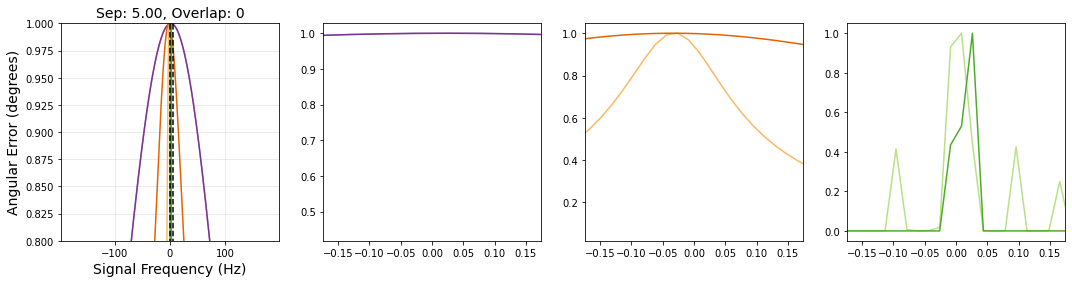

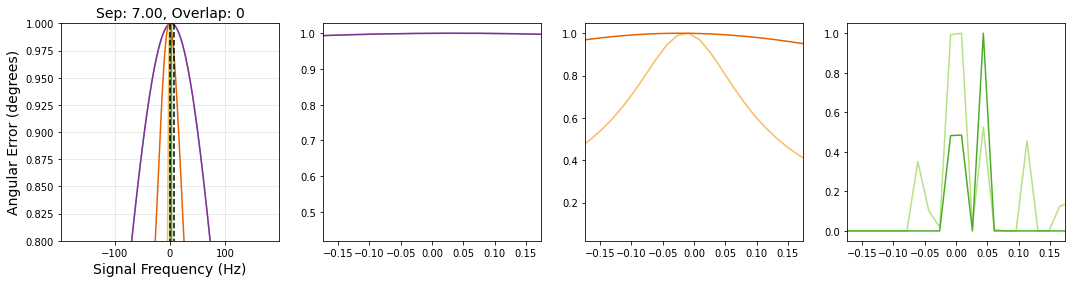

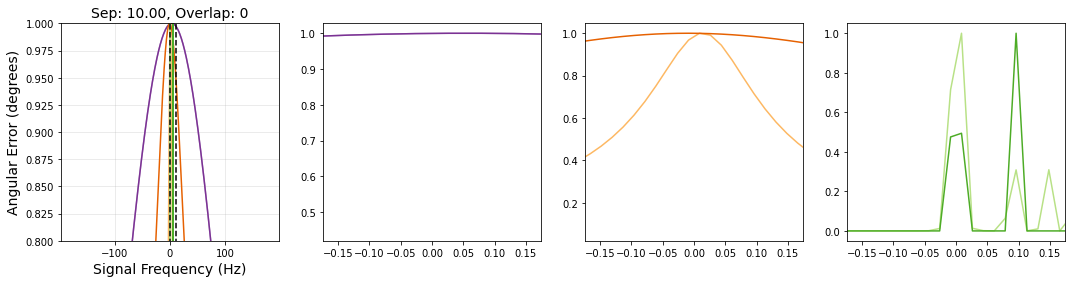

In [ ]:
separation_angles = np.pi/180 * np.array([5, 7, 10])
num_trials = 1

overall_errors = experimentTwoSignalsAcrossFrequenciesSimple(separation_angles, num_trials, overlap = 0, frequency = 3000, snr = 80)

Full overlap -> cannot distinguish

No separation angle -> cannot distinguish

In [ ]:
overall_errors['CAIM (t-f)'].shape

In [ ]:
# visualize how accuracy varies over frequency

for ov in range(len(overlap)):
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.grid(True, alpha=0.3)
    for method in overall_errors:
        method_mean = 180/np.pi * np.mean(overall_errors[method][:,ov,:], axis=1)
        method_sd = 180/np.pi * np.std(overall_errors[method][:,ov,:], axis=1)
        ax.plot(180/np.pi * separation_angles, method_mean, label=method)
        ax.fill_between(180/np.pi * separation_angles, method_mean - method_sd, method_mean + method_sd, alpha=0.2)

    plt.legend(loc='upper right', fontsize=12)
    plt.xlabel('Separation Angle (degrees)', fontsize=14)
    plt.ylabel('Angular Error (degrees)', fontsize=14)
    plt.title('DOA Estimation Error (mean +/- SD): overlap of ' + str(overlap[ov]), fontsize=16)
    plt.ylim([0, 90])
    plt.tight_layout()

#plt.savefig('angular_errors.png', dpi=200)

In [ ]:
np.tile(np.array(separation_angles), (5, 1)).T

In [ ]:
np.mean(overall_errors[method], axis=2)/np.tile(np.array(separation_angles), (5, 1)).T

In [ ]:
count = 1

plt.figure(figsize=(16, 16))
for method in overall_errors:
    plt.subplot(4, 4, count)
    plt.pcolor(overlap, 180/np.pi * separation_angles, 180/np.pi * np.mean(overall_errors[method], axis=2), vmin=0, vmax=90, cmap='RdYlGn_r')
    plt.colorbar()
    plt.title(method, fontsize=16)
    plt.xlabel('Overlap Amount')
    plt.ylabel('Separation Angle (degrees)')
    count = count + 1

plt.tight_layout()
#plt.savefig('errors.png', dpi=200)

In [ ]:
# --- Next steps: ---
# run all methods on the real-world data

# Real Data

In [ ]:
# mount drive!
from google.colab import drive
drive.mount('/content/drive')

%cd "drive/My Drive/Tolkova_Mahadevan/Source Separation Project/Colab Code"

Mounted at /content/drive
/content/drive/My Drive/Tolkova_Mahadevan/Source Separation Project/Colab Code


In [ ]:
folder = '/content/drive/MyDrive/Tolkova_Mahadevan/Source Separation Project/Signals/recordings'
figures_folder = '/content/drive/MyDrive/Tolkova_Mahadevan/Source Separation Project/Figures/'

### Functions for real data analysis

In [ ]:
def loadWav(file, folder):
    # ---- read in file ----
    filename = folder + '/' + file + '.wav'
    (signal, framerate) = librosa.core.load(filename, sr=None, mono=False)
    return signal, framerate

In [ ]:
def loadSignal(signal, framerate, start_time, end_time, n_fft = 1024, nf = 200, highpass_filter = 200):
    # ---- get part of signal ----
    s = signal[:, int(framerate * start_time):int(framerate * end_time)]
    s = s/np.max(s)

    #display(Audio(s, rate=framerate))

    # ---- filter signal ----
    s = butter_highpass_filter(s, highpass_filter, framerate)

    # ---- convert to b-format ----
    b_transform = np.asarray([[1, 1, 1, 1], [1, 1, -1, -1], [1, -1, 1, -1], [1, -1, -1, 1]])
    s_B = b_transform @ s

    # ---- make b-format spectrogram ----
    specs_B = []
    for num in np.arange(4):
        #freqs_B, inds_B, spec_B = scipysig.stft(s_B[num,:]/np.max(s_B[0,:]), fs=framerate, nperseg=n_fft)
        freqs_B, inds_B, spec_B = scipysig.stft(s_B[num,:], fs=framerate, nperseg=n_fft)
        freqs_B = freqs_B[0:nf]
        specs_B.append(spec_B[0:nf, :].T)

    return specs_B, s_B, inds_B, freqs_B

In [ ]:
def loadSignalMono(file, start_time, end_time, n_fft = 1024, nf = 200, highpass_filter = 200):
    # load in WAV file
    filename = folder + '/' + file
    (signal, framerate) = librosa.core.load(filename, sr=None, mono=False)

    # ---- get part of signal ----
    s = signal[:, int(framerate * start_time):int(framerate * end_time)]
    s = s/np.max(s)

    # ---- filter signal ----
    s = butter_highpass_filter(s, highpass_filter, framerate)

    # ---- make spectrograms ----
    specs = []
    for num in np.arange(len(s)):
        freqs, inds, spec = scipysig.stft(s[num]/np.max(s[num]), fs=framerate, nperseg=n_fft)
        freqs = freqs[0:nf]
        specs.append(spec[0:nf, :].T)

    return specs, s, inds, freqs

In [ ]:
def getAngularErrorReference(maxima, reference_maxima, azims, true_azimuth):
    error = {}
    for key in maxima:
        if (reference_maxima is not None):
            error[key] = angleErrorDegrees(azims[maxima[key]] - azims[reference_maxima[key]], true_azimuth)
        else:
            error[key] = angleErrorDegrees(azims[maxima[key]], true_azimuth)
    return error

In [ ]:
# angular error which accounts for rollover
def angleErrorDegrees(ang1, ang2):
    return np.abs(np.mod((ang1 - ang2 + 180), 360) - 180)

In [ ]:
# ---- filter methods! ----
def butter_highpass(cut, fs, order=5):
    nyq = 0.5 * fs
    cutoff = cut / nyq
    b, a = scipysig.butter(order, cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cut, fs, order=5):
    b, a = butter_highpass(cut, fs, order=order)
    y = scipysig.filtfilt(b, a, data)
    return y

In [ ]:
from numba.cuda.cudadrv import error
# --- methods to get angular maxima and errors when there are two sources ---

def getOutputMaximaAll(output, buffer=3):
    maxima = {}
    for key in output:
        maxima[key] = getBufferedMaxima(output[key], buffer=buffer)
    return maxima

def getBufferedMaxima(output, buffer=3):
    maxes = []
    output_temp = np.concatenate((output, output, output))
    for i in range(len(output)):
        if np.all(output_temp[len(output) + i] >= output_temp[(len(output) + i - buffer):(len(output) + i + buffer)]) and (output[i] > 0.25):
            maxes.append(i)

    # sort based on maximum values
    order = np.argsort(output[maxes])[::-1]

    # indices of maxima
    return np.array(maxes)[order]

def getAngularDistanceBetweenTwoSources(maxima, azims):
    diff = {}
    for key in maxima:
        # get largest max
        angle0 = azims[maxima[key][0]]

        # get second largest max (or some value if no second max)
        if (len(maxima[key]) == 1):
            angle1 = angle0
        else:
            angle1 = azims[maxima[key][1]]

        diff[key] = angleErrorDegrees(angle0, angle1)

    return diff

## One source, changing azimuth

### Functions

In [ ]:
## --------------- ANALYSIS OF CHANGING AZIMUTH ---------------

def experimentAzimuth(num_azim = num_azim):
    # These are recordings from July 2021:
    file = '07_04_2021_azimuth_experiment_marymoor'
    full_note_duration = 1.0
    true_angles = np.array([0, 60, 120, -180, -120, -60])
    start_times = [18.95, 41.2, 62.92, 89.42, 115.92, 138.42]
    call_times = [0, 1.5, 3.29, 4.78, 6.66, 8.16]

    # signal and FFT parameters

    # DOA estimation parameters
    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    signal, framerate = loadWav(file, folder)

    overall_outputs = {}
    overall_errors = {}

    reference_maxima = None

    for trial in range(len(start_times)):
        specs_B_ni, s_B_ni, inds_B_ni, freqs_B_ni = loadSignal(signal, framerate, start_time=10,
                                                              end_time = 16, nf = nf, n_fft=n_fft,
                                                              highpass_filter=highpass_filter)

        specs_B_flat_ni = np.array([spec.ravel() for spec in specs_B_ni])

        for call in range(6):
            specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[trial] + call_times[call],
                                                      end_time = start_times[trial] + call_times[call] + full_note_duration,
                                                      nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)

            # run all current methods and return a huge output dictionary
            output = runAllMethods(s_B, specs_B, num_azim, num_alti = 0, s_B_ni = s_B_ni, specs_B_flat_ni = specs_B_flat_ni, music_sources = 1, wnc_param = wnc_param)

            # get maxima of angles corresponding to this output?
            maxima = getOutputMaxima(output)
            # if (reference_maxima is None):
            #     reference_maxima = maxima

            # get accuracy corresponding to this output?
            errors = getAngularErrorReference(maxima, reference_maxima, azims, true_angles[trial])

            # if the dictionary doesn't exist yet, initialize it
            if (len(overall_errors) == 0):
                for key in errors:
                    overall_errors[key] = np.zeros((len(start_times), 6))
                    overall_outputs[key] = np.zeros((len(start_times), 6, num_azim))

            # place angular error in correct place in main output dictionary
            for key in errors:
                overall_errors[key][trial, call] = errors[key]
                overall_outputs[key][trial, call] = output[key]

            if (trial == 0):
                plt.figure()
                plt.pcolormesh(logTransform(np.abs(specs_B[0].T)), linewidth=0, rasterized=True)

    return overall_outputs, overall_errors, true_angles, start_times

In [ ]:
def plotSingleAzimuthTrial(trial = 2, call = 0, num_azim = num_azim, SAVEFIG = None):
    # These are recordings from July 2021:
    file = '07_04_2021_azimuth_experiment_marymoor'
    full_note_duration = 1.0
    true_angles = np.array([0, 60, 120, -180, -120, -60])
    start_times = [18.95, 41.2, 62.92, 89.42, 115.92, 138.42]
    call_times = [0, 1.5, 3.29, 4.78, 6.66, 8.16]

    # signal and FFT parameters

    # DOA estimation parameters
    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    signal, framerate = loadWav(file, folder)

    specs_B_ni, s_B_ni, inds_B_ni, freqs_B_ni = loadSignal(signal, framerate, start_time=10,
                                                              end_time = 16, nf = nf, n_fft=n_fft,
                                                              highpass_filter=highpass_filter)

    specs_B_flat_ni = np.array([spec.ravel() for spec in specs_B_ni])


    specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[trial] + call_times[call],
                                              end_time = start_times[trial] + call_times[call] + full_note_duration,
                                              nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)

    # run all current methods and return a huge output dictionary
    output = runAllMethods(s_B, specs_B, num_azim, num_alti = 0, s_B_ni = s_B_ni, specs_B_flat_ni = specs_B_flat_ni, music_sources = 1, wnc_param = wnc_param)

    print('time-domain shape: ', s_B.shape)
    print('time-frequency-domain shape: ', specs_B[0].shape)

    fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
    plt.pcolormesh(inds_B, freqs_B/1000, logTransform(np.abs(specs_B[0].T)), linewidth=0, rasterized=True)
    ax.set_title('Spectrogram', fontsize=16)
    #ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
    ax.set_xlabel('Time (sec)', fontsize=13)
    ax.set_ylabel('Frequency (kHz)', fontsize=13)
    #plt.colorbar()
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('one_source_example_real_spec' + SAVEFIG + '.png', dpi=200)
            fig.savefig('one_source_example_real_spec' + SAVEFIG + '.pdf', dpi=200)

    wcaim = WCAIM()
    wcaim.scan(specs_B, num_azim)

    fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
    plt.pcolormesh(inds_B, freqs_B/1000, wcaim.azimuth.T * 180/np.pi, cmap='hsv', linewidth=0, rasterized=True)
    ax.set_title('Azigram', fontsize=16)
    ax.set_xlabel('Time (sec)', fontsize=13)
    ax.set_ylabel('Frequency (kHz)', fontsize=13)
    #plt.colorbar(ticks = [-180, -120, -60, 0, 60, 120, 180])
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('one_source_example_real_azim' + SAVEFIG + '.png', dpi=200)
            fig.savefig('one_source_example_real_azim' + SAVEFIG + '.pdf', dpi=200)

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
    for method in output:
        ax.plot(azims, output[method], label=method)
        ax.plot([true_angles[trial], true_angles[trial]], [0, 1], 'k--')
        #ax_output.legend(loc='upper left', fontsize=12)
        ax.set_xlabel('Azimuth (degrees)', fontsize=13)
        ax.set_ylabel('Normalized DOA Metric', fontsize=13)
        ax.set_title('DOA Estimate', fontsize=16)
        ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
        ax.set_xlim([-180, 180])

    #ax.legend(loc='upper left', fontsize=12)
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('one_source_example_real_dist' + SAVEFIG + '.png', dpi=200)
            fig.savefig('one_source_example_real_dist' + SAVEFIG + '.pdf', dpi=200)

    return output

### Results and Figures

In [ ]:
overall_outputs, overall_errors, true_angles, start_times = experimentAzimuth(num_azim = num_azim)

In [ ]:
overall_errors

{'AIM (t-f)': array([[6.5, 6.5, 6.5, 7.5, 6.5, 6.5],
        [6.5, 5.5, 5.5, 5.5, 6.5, 6.5],
        [4.5, 3.5, 4.5, 4.5, 3.5, 4.5],
        [0.5, 0.5, 0.5, 1.5, 0.5, 0.5],
        [3.5, 2.5, 2.5, 2.5, 2.5, 2.5],
        [7.5, 7.5, 7.5, 7.5, 8.5, 8.5]]),
 'AIM (time)': array([[ 9.5,  9.5,  9.5,  7.5,  8.5,  8.5],
        [ 3.5,  5.5,  5.5,  4.5,  4.5,  4.5],
        [ 1.5,  1.5,  1.5,  2.5,  1.5,  2.5],
        [ 0.5,  0.5,  1.5,  4.5,  1.5,  1.5],
        [ 4.5,  5.5,  4.5,  3.5,  3.5,  3.5],
        [11.5, 12.5, 12.5, 12.5,  9.5, 14.5]]),
 'MUSIC (t-f)': array([[ 8.5,  7.5,  8.5,  7.5,  7.5,  7.5],
        [ 4.5,  4.5,  4.5,  8.5,  4.5,  6.5],
        [ 2.5,  2.5,  2.5,  2.5,  2.5,  3.5],
        [ 0.5,  0.5,  0.5,  0.5,  2.5,  0.5],
        [ 3.5,  3.5,  3.5,  3.5,  2.5,  3.5],
        [ 9.5, 10.5,  9.5, 10.5, 10.5, 10.5]]),
 'MUSIC (time)': array([[ 8.5,  7.5,  7.5,  7.5,  7.5,  7.5],
        [ 4.5,  4.5,  4.5,  8.5,  4.5,  6.5],
        [ 2.5,  2.5,  2.5,  2.5,  2.5,  3.5],
      

In [ ]:
print('-----------------------------------------------------------------------------')
print('Errors (in degrees) for a single source, relative to the 0 degree measurement')
print('-----------------------------------------------------------------------------')
for method in overall_errors:
    print('%s -- $%.2f \pm %.2f$' % (method, np.mean(overall_errors[method]), np.std(overall_errors[method])))

-----------------------------------------------------------------------------
Errors (in degrees) for a single source, relative to the 0 degree measurement
-----------------------------------------------------------------------------
WNC (t-f) -- $9.86 \pm 7.75$
WNC (time) -- $28.28 \pm 27.04$
MUSIC (t-f) -- $5.06 \pm 3.27$
MUSIC (time) -- $5.14 \pm 3.40$
AIM (t-f) -- $4.67 \pm 2.49$
AIM (time) -- $5.56 \pm 3.92$


In [ ]:
# fig_output, ax_output = plt.subplots(2, 3, figsize=(18, 10))
# for trial in range(len(start_times)):
#     ax_output[trial//3, trial % 3].grid(True, alpha=0.3)
#     for method in output:
#         ax_output[trial//3, trial % 3].plot(azims, np.mean(overall_outputs[method][trial], axis=0), label=method)
#         line_position = true_angles[trial] - azims[reference_maxima[method]]
#         ax_output[trial//3, trial % 3].plot([true_angles[trial], true_angles[trial]], [0, 1], 'k--')
#         #ax_output.legend(loc='upper left', fontsize=12)
#         ax_output[trial//3, trial % 3].set_xlabel('Signal Frequency (Hz)', fontsize=14)
#         ax_output[trial//3, trial % 3].set_ylabel('Angular Error (degrees)', fontsize=14)
#         ax_output[trial//3, trial % 3].set_title('Azimuth = ' + str(np.round(true_angles[trial])))

#     plt.legend()

# fig_output.tight_layout()

time-domain shape:  (4, 48000)
time-frequency-domain shape:  (95, 214)


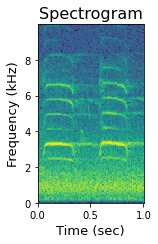

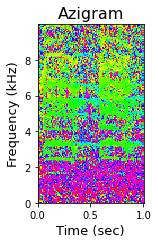

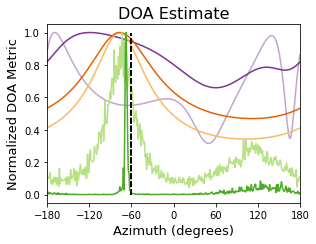

In [ ]:
#output = plotSingleAzimuthTrial(trial = 5, call = 2, num_azim = num_azim, SAVEFIG='_04_29_2022')
output = plotSingleAzimuthTrial(trial = 5, call = 2, num_azim = num_azim, SAVEFIG=False)

## Number of Azimuth Bins

### Functions

In [ ]:
def experimentResolution():
    file = '07_04_2021_azimuth_experiment_marymoor'
    full_note_duration = 1.
    true_angles = np.array([60])
    start_times = [41.2]
    call_times = [0, 1.5, 3.29, 4.78, 6.66, 8.16]
    signal, framerate = loadWav(file, folder)


    num_azims = [30, 60, 90, 180, 360, 2 * 360, 4 * 360, 10 * 360, 100 * 360, 1000*360, 10000*360]

    true_angles = np.array([0, 60, 120, -180, -120, -60])
    start_times = [18.95, 41.2, 62.92, 89.42, 115.92, 138.42]


    for trial in range(len(start_times)):
        for call in range(len(call_times)):
            specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate,
                                                      start_time=start_times[trial] + call_times[call],
                                                      end_time = start_times[trial] + call_times[call] + full_note_duration,
                                                      nf = nf, n_fft=n_fft,
                                                      highpass_filter=highpass_filter)

            average_pixels_per_bin = [specs_B[0].size/(num_azim) for num_azim in num_azims]
            errors = np.zeros((len(call_times), len(num_azims)))

            for i in range(len(num_azims)):
                azim_edges = np.linspace(-180, 180, num_azims[i] + 1)
                azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

                wcaim = WCAIM()
                output_aim_tf = wcaim.scan(specs_B, num_azims[i])

                errors[trial, i] = angleErrorDegrees(azims[np.argmax(output_aim_tf)], true_angles[trial])

        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.errorbar(average_pixels_per_bin, np.mean(errors, axis=0), yerr=np.std(errors, axis=0))
        ax.set_xscale('log')

### Results and Figures

In [ ]:
# file = '07_04_2021_azimuth_experiment_marymoor'
# full_note_duration = 1.
# true_angles = np.array([60])
# start_times = [41.2]
# call_times = [0, 1.5, 3.29, 4.78, 6.66, 8.16]
# signal, framerate = loadWav(file, folder)

In [ ]:
file = '07_11_2021_distance_experiment_lwhs'
full_note_duration = 1 #0.3
true_angles = np.array([0, 60, 120, -180, -120, -60])
start_times = [20.60, 38.61, 56.11, 101.96, 126.34, 146.27]
call_times = [0, 1.5, 3.29, 4.78, 6.66, 8.16] #[0, 0.54, 1.51, 2.15, 3.33, 3.87, 4.83, 5.50, 6.75, 7.29, 8.25, 8.90]

signal, framerate = loadWav(file, folder)

In [ ]:
highpass_filter = 2000

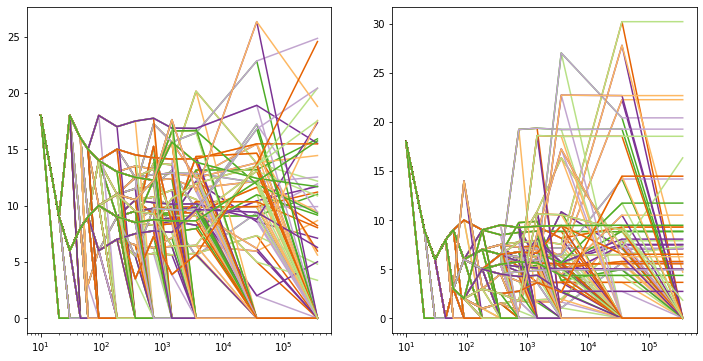

In [ ]:
# load in a signal
# iteratively repeat AIM (time) and AIM (t-f) estimation with different numbers of azimuth bins
# make list of

num_azims = [10, 20, 30, 45, 60, 90, 180, 360, 2 * 360, 4 * 360, 10 * 360, 100 * 360, 1000*360]

true_angle = 0
errors_time = np.zeros((6, len(call_times), len(num_azims)))
errors_tf = np.zeros((6, len(call_times), len(num_azims)))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for trial in range(len(start_times)):
    for call in range(len(call_times)):
        specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate,
                                                  start_time=start_times[trial] + call_times[call],
                                                  end_time = start_times[trial] + call_times[call] + full_note_duration,
                                                  nf = nf, n_fft=n_fft,
                                                  highpass_filter=highpass_filter)

        average_pixels_per_bin = [specs_B[0].size/(num_azim) for num_azim in num_azims]

        for i in range(len(num_azims)):
            azim_edges = np.linspace(-180, 180, num_azims[i] + 1)
            azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

            wcaim = WCAIM()
            output_aim_tf = wcaim.scan(specs_B, num_azims[i])

            wcaim = WCAIM()
            output_aim_time = wcaim.scan(s_B, num_azims[i])

            errors_time[trial, call, i] = angleErrorDegrees(azims[np.argmax(output_aim_time)], true_angle)
            errors_tf[trial, call, i] = angleErrorDegrees(azims[np.argmax(output_aim_tf)], true_angle)

            ax[0].plot(num_azims, errors_time[trial, call, :])
            ax[1].plot(num_azims, errors_tf[trial, call, :])

ax[0].set_xscale('log')
ax[1].set_xscale('log')

Text(0.5, 1.0, 'Angular Error over Histogram Bin Count')

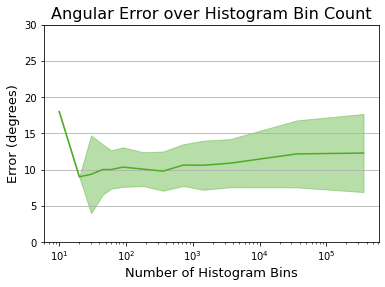

In [ ]:
error_mean_time = np.mean(errors_time, axis=(1, 0))
error_sd_time = np.std(errors_time, axis=(1, 0))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(num_azims, error_mean, color="#4dac26")
ax.fill_between(num_azims, error_mean - error_sd, error_mean + error_sd, alpha=0.4, color="#4dac26")
ax.set_xscale('log')
ax.set_ylim([0, 30])
ax.yaxis.grid(True)
plt.xlabel('Number of Histogram Bins', fontsize=13)
plt.ylabel('Error (degrees)', fontsize=13)
plt.title('Angular Error over Histogram Bin Count', fontsize=16)
#plt.savefig('histogram_bin_count.png', dpi=200)
#plt.savefig('histogram_bin_count.pdf', dpi=200)

In [ ]:
for method in output:
  print(method)

NameError: ignored

In [ ]:
colors

['#c2a5cf', '#7b3294', '#fdb863', '#e66101', '#b8e186', '#4dac26']

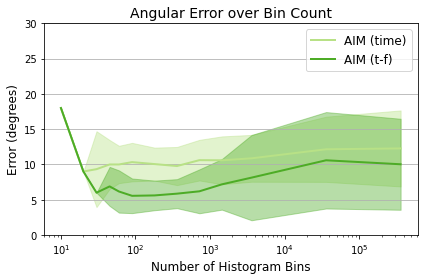

In [ ]:
error_mean_time = np.mean(errors_time, axis=(1, 0))
error_sd_time = np.std(errors_time, axis=(1, 0))

error_mean_tf = np.mean(errors_tf, axis=(1, 0))
error_sd_tf = np.std(errors_tf, axis=(1, 0))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(num_azims, error_mean_time, color=colors[4], linewidth=2, label='AIM (time)')
ax.fill_between(num_azims, error_mean_time - error_sd_time, error_mean_time + error_sd_time, alpha=0.4, color=colors[4])

ax.plot(num_azims, error_mean_tf, color=colors[5], linewidth=2, label='AIM (t-f)')
ax.fill_between(num_azims, error_mean_tf - error_sd_tf, error_mean_tf + error_sd_tf, alpha=0.4, color=colors[5])
ax.set_xscale('log')
ax.set_ylim([0, 30])
ax.yaxis.grid(True)
plt.xlabel('Number of Histogram Bins', fontsize=12)
plt.ylabel('Error (degrees)', fontsize=12)
plt.title('Angular Error over Bin Count', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('histogram_bin_count.png', dpi=200)
plt.savefig('histogram_bin_count.pdf', dpi=200)

## Source Duration Experiment

### Functions

In [ ]:
def makeDurationLinePlot(overall_errors, start_times, durations, ylimits, SAVE_FILENAME=False):
    #colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # calculate both means and stds across trials
    num_trials = len(start_times)
    num_methods = len(overall_errors)
    diff_means = {}
    diff_sds = {}

    for method in overall_errors:
        diff_means[method] = np.zeros((len(durations)))
        diff_sds[method] = np.zeros((len(durations)))

    for i in range(len(durations)):
        for method in overall_errors:
            diff_means[method][i] = np.mean(overall_errors[method][1:, i])
            diff_sds[method][i] = np.std(overall_errors[method][1:, i])

    print(diff_means)
    print(diff_sds)

    fig, ax = plt.subplots(figsize=(9.5, 4))
    for method in overall_errors:
        plt.errorbar(durations, diff_means[method], yerr=diff_sds[method], uplims=True, lolims=True, label=method)

    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)
    plt.title('Angular Error Over Source Duration', fontsize=16)
    plt.xlabel('Duration (seconds)', fontsize=14)
    plt.ylabel('Error (degrees)', fontsize=14)
    ax.yaxis.grid(True)
    #ax.set_xscale('log')
    if (ylimits is not None):
        ax.set_ylim(ylimits)

    plt.tight_layout()

    if (SAVE_FILENAME):
        plt.savefig(figures_folder + 'duration_lineplot' + SAVE_FILENAME + '.png', dpi=200)
        plt.savefig(figures_folder + 'duration_lineplot' + SAVE_FILENAME + '.pdf', dpi=200)

    # make the bar plot
    ind = np.arange(len(durations))  # the x locations for the groups
    width = 0.4  # the width of the bars
    pos = [5/6, 3/6, 1/6, -1/6, -3/6, -5/6]

    fig, ax = plt.subplots(figsize=(9.5, 4))

    for i, method in enumerate(overall_errors):
        plt.bar(ind + pos[i] * width, diff_means[method], width/3, yerr=diff_sds[method], label=method)

    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)
    plt.title('Angular Error Over Source Duration', fontsize=17)
    plt.xlabel('Duration (seconds)', fontsize=14)
    plt.ylabel('Error (degrees)', fontsize=14)
    ax.yaxis.grid(True)
    ax.set_xticks(ind)
    ax.set_xticklabels(durations)
    plt.gca().invert_xaxis()
    if (ylimits is not None):
        ax.set_ylim(ylimits)

    plt.tight_layout()

    if (SAVE_FILENAME):
        plt.savefig(figures_folder + 'duration_barplot' + SAVE_FILENAME + '.png', dpi=200)
        plt.savefig(figures_folder + 'duration_barplot' + SAVE_FILENAME + '.pdf', dpi=200)

#plt.savefig(figures_folder + 'azimuth_with_duration_error_highpass' + str(highpass_filter) + '_sqrt3.pdf', dpi=300)
#plt.savefig(figures_folder + 'azimuth_with_duration_error_highpass' + str(highpass_filter) + '_sqrt3.png', dpi=300)

# plt.show()

# fig, ax = plt.subplots(figsize=(8, 5))
# plt.errorbar(distances, diff_means[0,:], yerr=diff_sds[0,:], uplims=True, lolims=True, label='MUSIC (1D)')
# plt.errorbar(distances, diff_means[1,:], yerr=diff_sds[1,:], uplims=True, lolims=True, label='MUSIC (2D)')
# plt.errorbar(distances, diff_means[2,:], yerr=diff_sds[2,:], uplims=True, lolims=True, label='CAIM')
# plt.errorbar(distances, diff_means[3,:], yerr=diff_sds[3,:], uplims=True, lolims=True, label='WCAIM')
# plt.legend(loc='upper left', fontsize=13)
# plt.title('Angular Error Over Source Distance', fontsize=16)
# plt.xlabel('Distance (yards)', fontsize=14)
# plt.ylabel('Error (degrees)', fontsize=14)
# ax.yaxis.grid(True)
# plt.ylim([0, 25])

#plt.savefig(figures_folder + 'azimuth_with_distance_error_highpass' + str(highpass_filter) + '.png', dpi=300)
#plt.savefig(figures_folder + 'azimuth_with_distance_error_highpass' + str(highpass_filter) + '.pdf', dpi=300)

# plt.show()

In [ ]:
def durationExperiment(num_azim_per_one_sec = 360):
    ## --------------- ANALYSIS OF CHANGING DURATION ---------------

    ## recordings taken in July 2021
    file = '07_04_2021_duration_experiment_marymoor'

    start_times = [2.13, 7.67, 12.06, 17.28, 21.84, 27.39, 31.76, 37.00]
    durations = [2, 1, 0.5, 0.2, 0.1, 0.05, 0.01]
    num_trials = len(start_times)
    true_angle = 0

    signal, framerate = loadWav(file, folder)

    overall_outputs = {}
    overall_errors = {}

    reference_maxima = None

    overall_outputs = {}
    overall_errors = {}

    num_azim = num_azim_per_one_sec
    # num_azim = int(np.max([np.round(num_azim_per_one_sec * durations[i]), 60]))
    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    specs_B_ni, s_B_ni, inds_B_ni, freqs_B_ni = loadSignal(signal, framerate, start_time = 5,
                                                            end_time = 7, nf = nf, n_fft=n_fft,
                                                            highpass_filter=highpass_filter)

    specs_B_flat_ni = np.array([spec.ravel() for spec in specs_B_ni])


    fig, ax = plt.subplots(len(start_times), len(durations), figsize=(24, 15))

    for i in range(len(durations)):
        for j in range(len(start_times)):
            specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[j],
                                                      end_time = start_times[j] + durations[i],
                                                      nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)


            # run all current methods and return a huge output dictionary
            output = runAllMethods(s_B, specs_B, num_azim, num_alti = 0, s_B_ni = s_B_ni, specs_B_flat_ni = specs_B_flat_ni, music_sources = 1, wnc_param = wnc_param)

            # get maxima of angles corresponding to this output?
            maxima = getOutputMaxima(output)
            #if (reference_maxima is None):
            #    reference_maxima = maxima

            # get accuracy corresponding to this output?
            errors = getAngularErrorReference(maxima, reference_maxima, azims, true_angle)

            # if the dictionary doesn't exist yet, initialize it
            if (len(overall_errors) == 0):
                for key in errors:
                    overall_errors[key] = np.zeros((len(start_times), len(durations)))
                    overall_outputs[key] = np.zeros((len(start_times), len(durations), num_azim))

            # place angular error in correct place in main output dictionary
            for key in errors:
                overall_errors[key][j, i] = errors[key]
                #overall_outputs[key][j, i] = output[key]

            ax[j, i].pcolormesh(logTransform(np.abs(specs_B[0].T)), linewidth=0, rasterized=True)

    return overall_outputs, overall_errors, durations, start_times

### Results and Figures

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 1024 is greater than input length  = 479, using nperseg = 479
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 1024 is greater than input length  = 480, using nperseg = 480
  .format(nperseg, input_length))


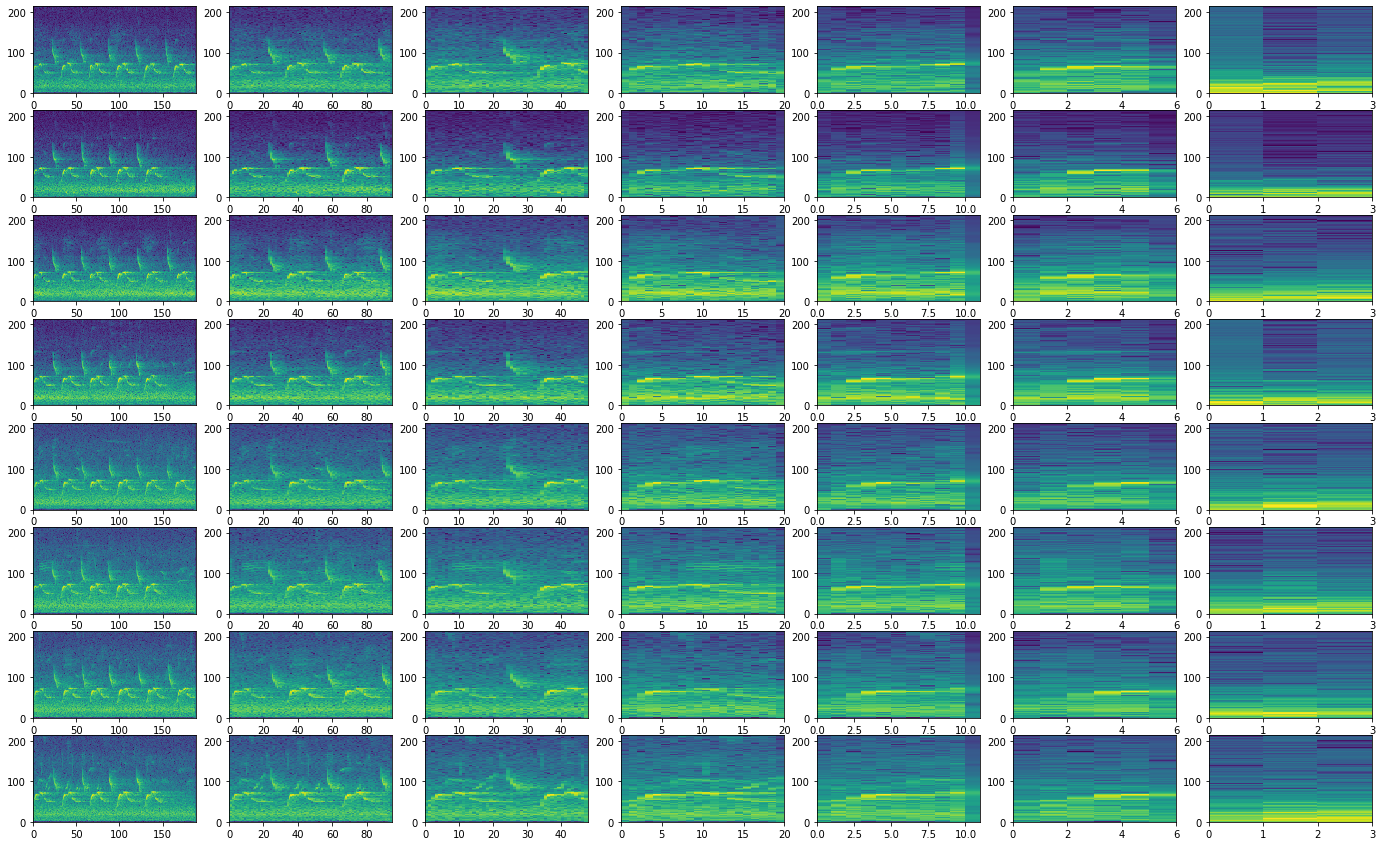

In [ ]:
overall_outputs, overall_errors, durations, start_times = durationExperiment(num_azim_per_one_sec = 360)

{'WNC (time)': array([  3.5       ,  27.92857143,  10.5       ,  58.5       ,
        59.21428571,  18.92857143, 135.07142857]), 'WNC (t-f)': array([  1.92857143,   1.92857143,   3.21428571,  46.07142857,
        45.21428571,  24.78571429, 113.21428571]), 'MUSIC (time)': array([  5.64285714,  10.64285714,  15.35714286,  42.64285714,
        36.92857143,  17.21428571, 111.07142857]), 'MUSIC (t-f)': array([  5.07142857,   9.64285714,  15.92857143,  42.5       ,
        37.5       ,  17.07142857, 113.07142857]), 'AIM (time)': array([  7.5       ,   8.07142857,   7.35714286,  48.35714286,
        48.35714286,  27.21428571, 102.35714286]), 'AIM (t-f)': array([  8.5       ,   8.64285714,   8.92857143,   8.35714286,
         8.35714286,   8.21428571, 104.92857143])}
{'WNC (time)': array([ 1.51185789, 52.51899559,  2.32992949, 63.30425398, 63.45462785,
        1.67819145, 46.31216176]), 'WNC (t-f)': array([ 1.84058553,  1.76126114,  1.90595201, 66.450534  , 66.9705997 ,
       52.97901009, 47.

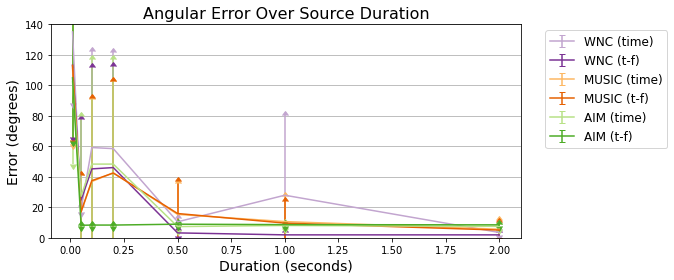

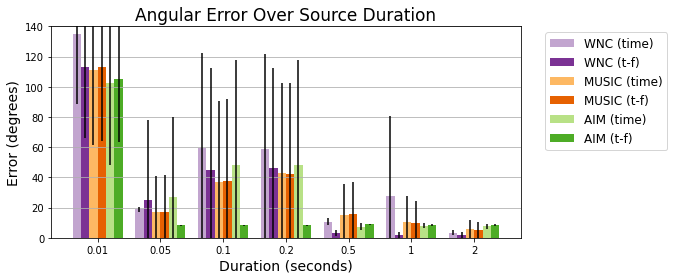

In [ ]:
makeDurationLinePlot(overall_errors, start_times, durations, ylimits=[0, 140], SAVE_FILENAME = '_' + str(highpass_filter) + 'hz_04_29_2022')
# SAVE_FILENAME = '_' + str(highpass_filter) + 'hz_04_15_2022'
#SAVE_FILENAME = '_' + str(highpass_filter) + 'hz_04_15_2022'
#SAVE_FILENAME = '_200hz_04_14_2022'

## Source SNR Experiment

In [ ]:
def plotSingleDistanceTrial(trial = 2, call = 0, num_azim = num_azim, highpass_filter=highpass_filter, SAVEFIG=False):
    # These are recordings from July 2021:
    file = '07_11_2021_distance_experiment_lwhs'
    full_note_duration = 1 #0.3
    true_angles = np.array([0, 60, 120, -180, -120, -60])
    start_times = [20.60, 38.61, 56.11, 81.97, 101.96, 126.34, 146.27, 165.38]
    call_times = [0, 1.5, 3.29, 4.78, 6.66, 8.16] #[0, 0.54, 1.51, 2.15, 3.33, 3.87, 4.83, 5.50, 6.75, 7.29, 8.25, 8.90]

    # DOA estimation parameters
    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    signal, framerate = loadWav(file, folder)

    specs_B_ni, s_B_ni, inds_B_ni, freqs_B_ni = loadSignal(signal, framerate, start_time = 31,#start_times[trial] - 2,
                                                                end_time = 37,#start_times[trial],
                                                                nf = nf, n_fft=n_fft,
                                                                highpass_filter=highpass_filter)

    specs_B_flat_ni = np.array([spec.ravel() for spec in specs_B_ni])


    specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[trial] + call_times[call],
                                                      end_time = start_times[trial] + call_times[call] + full_note_duration,
                                                      nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)


    # run all current methods and return a huge output dictionary
    output = runAllMethods(s_B, specs_B, num_azim, num_alti = 0, s_B_ni = s_B_ni, specs_B_flat_ni = specs_B_flat_ni, music_sources = 1, wnc_param = wnc_param)

    fig, ax = plt.subplots(1, 1, figsize=(2.5, 3.5))
    ax.pcolormesh(inds_B, freqs_B, logTransform(np.abs(specs_B[0].T)), linewidth=0, rasterized=True)
    ax.set_title('Spectrogram', fontsize=16)
    ax.set_xlabel('Time (sec)', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    fig.tight_layout()
    if (SAVEFIG):
        fig.savefig('distance_trial_%d_call_%d_highpass_%d_spec.png' % (trial, call, highpass_filter), dpi=200)
        fig.savefig('distance_trial_%d_call_%d_highpass_%d_spec.pdf' % (trial, call, highpass_filter), dpi=200)

    wcaim = WCAIM()
    wcaim.scan(specs_B, num_azim)

    fig, ax = plt.subplots(1, 1, figsize=(2.8, 3.5))
    plt.pcolormesh(inds_B, freqs_B/1000, wcaim.azimuth.T * 180/np.pi, cmap='hsv', linewidth=0, rasterized=True)
    ax.set_title('Azigram', fontsize=16)
    ax.set_xlabel('Time (sec)', fontsize=13)
    ax.set_ylabel('Frequency (kHz)', fontsize=13)
    plt.colorbar(ticks = [-180, -120, -60, 0, 60, 120, 180])
    fig.tight_layout()
    if (SAVEFIG):
        fig.savefig('distance_trial_%d_call_%d_highpass_%d_azim.png' % (trial, call, highpass_filter), dpi=200)
        fig.savefig('distance_trial_%d_call_%d_highpass_%d_azim.pdf' % (trial, call, highpass_filter), dpi=200)

    fig, ax = plt.subplots(1, 1, figsize=(6.5, 3.5))
    for method in output:
        ax.plot(azims, output[method], label=method)
        #ax.plot([true_angles[trial], true_angles[trial]], [0, 1], 'k--')
        #ax_output.legend(loc='upper left', fontsize=12)
        ax.set_xlabel('Azimuth (degrees)', fontsize=13)
        ax.set_ylabel('Normalized DOA Metric', fontsize=13)
        ax.set_title('DOA Estimates', fontsize=16)
        ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
        ax.set_xlim([-180, 180])

    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)
    fig.tight_layout()
    if (SAVEFIG):
        fig.savefig('distance_trial_%d_call_%d_highpass_%d_DOA.png' % (trial, call, highpass_filter), dpi=200)
        fig.savefig('distance_trial_%d_call_%d_highpass_%d_DOA.pdf' % (trial, call, highpass_filter), dpi=200)

    return output, specs_B,

In [ ]:
def experimentSNR(num_azim = num_azim):

    ## recordings taken in July 2021 with slightly longer blue jay call
    file = '07_11_2021_distance_experiment_lwhs'
    start_times = [20.60, 38.61, 56.11, 81.97, 101.96, 126.34, 146.27, 165.38]
    note_start_times = [0, 1.5, 3.29, 4.78, 6.66, 8.16] #[0, 0.54, 1.51, 2.15, 3.33, 3.87, 4.83, 5.50, 6.75, 7.29, 8.25, 8.90]

    true_angle = 0
    full_note_duration = 1#0.3

    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    distances = [5, 10, 15, 20, 25, 30, 35, 40] # this is in yards
    distances_meters = [dist * 0.9144 for dist in distances]

    num_trials = len(note_start_times)

    signal, framerate = loadWav(file, folder)

    reference_maxima = None
    overall_outputs = {}
    overall_errors = {}

    fig, ax = plt.subplots(len(note_start_times), len(distances), figsize=(24, 15))

    for i in range(len(distances)):
        specs_B_ni, s_B_ni, inds_B_ni, freqs_B_ni = loadSignal(signal, framerate, start_time = 31,#start_times[i] - 2,
                                                                end_time = 37,#start_times[i],
                                                                nf = nf, n_fft=n_fft,
                                                                highpass_filter=highpass_filter)

        specs_B_flat_ni = np.array([spec.ravel() for spec in specs_B_ni])

        for j in range(num_trials):
            specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[i] + note_start_times[j],
                                                      end_time = start_times[i] + note_start_times[j] + full_note_duration,
                                                      nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)

            # run all current methods and return a huge output dictionary
            output = runAllMethods(s_B, specs_B, num_azim, num_alti = 0, s_B_ni = s_B_ni, specs_B_flat_ni = specs_B_flat_ni, music_sources = 1, wnc_param = wnc_param)

            # get maxima of angles corresponding to this output?
            maxima = getOutputMaxima(output)
            #if (reference_maxima is None):
            #    reference_maxima = maxima

            # get accuracy corresponding to this output?
            errors = getAngularErrorReference(maxima, reference_maxima, azims, true_angle)

            # if the dictionary doesn't exist yet, initialize it
            if (len(overall_errors) == 0):
                for key in errors:
                    overall_errors[key] = np.zeros((len(note_start_times), len(distances)))
                    overall_outputs[key] = np.zeros((len(note_start_times), len(distances), num_azim))

            # place angular error in correct place in main output dictionary
            for key in errors:
                overall_errors[key][j, i] = errors[key]
                overall_outputs[key][j, i] = output[key]

            ax[j, i].pcolormesh(logTransform(np.abs(specs_B_ni[0].T)), linewidth=0, rasterized=True)

    return overall_outputs, overall_errors, distances_meters

In [ ]:
def makeDistanceLinePlot(overall_errors, distances, ylimits, SAVE_FILENAME=False):
    # #colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # amplitude_noise_200hz = np.array([-59.63, -60.36, -60.52, -59.89, -60.06, -60.96, -60.58, -59.97])
    # amplitude_noise_2khz = np.array([-78.55, -78.12, -77.46, -76.80, -77.78, -77.93, -77.71, -77.54])
    # amplitude_signal = np.array([-37.64, -45.31, -48.79, -55.49, -52.00, -55.99, -60.37, -64.26])
    # snr_200hz = amplitude_signal - amplitude_noise_200hz
    # snr_2khz = amplitude_signal - amplitude_noise_2khz

    # put in sorted order
    # if (highpass_filter == 2000):
    #     snr = snr_2khz
    # elif (highpass_filter == 200):
    #     snr = snr_200hz

    # reorder
    snr = np.array([20.8, 12.2,  9.9,  0.8,  6.5,  2.2, -1.8, -5.7])

    snr_order = np.argsort(snr)

    # calculate both means and stds across trials
    num_trials = overall_errors['AIM (t-f)'].shape[0]
    num_methods = len(overall_errors)
    diff_means = {}
    diff_sds = {}

    for method in overall_errors:
        diff_means[method] = np.zeros((len(distances)))
        diff_sds[method] = np.zeros((len(distances)))

    for i in range(len(distances)):
        for method in overall_errors:
            diff_means[method][i] = np.mean(overall_errors[method][1:,i])
            diff_sds[method][i] = np.std(overall_errors[method][1:,i])

    print(diff_means)
    print(diff_sds)

    ## Distance plots

    fig, ax = plt.subplots(figsize=(9.5, 4))
    for method in overall_errors:
        plt.errorbar(distances, diff_means[method], yerr=diff_sds[method], uplims=True, lolims=True, label=method)

    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)
    plt.title('Angular Error Over Source Distance', fontsize=17)
    plt.xlabel('Distances (meters)', fontsize=14)
    plt.ylabel('Error (degrees)', fontsize=14)
    ax.yaxis.grid(True)
    plt.ylim(ylimits)
    plt.tight_layout()

    if (SAVE_FILENAME):
        plt.savefig(figures_folder + 'distance_lineplot' + SAVE_FILENAME + '.png', dpi=200)
        plt.savefig(figures_folder + 'distance_lineplot' + SAVE_FILENAME + '.pdf', dpi=200)

    # make the bar plot
    ind = np.arange(len(distances))  # the x locations for the groups
    width = 0.3  # the width of the bars
    pos = [5/6, 3/6, 1/6, -1/6, -3/6, -5/6]

    fig, ax = plt.subplots(figsize=(9.5, 4))

    for i, method in enumerate(overall_errors):
        plt.bar(ind + pos[i] * width, diff_means[method], width/3, yerr=diff_sds[method], label=method)

    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)
    plt.title('Angular Error Over Source Distance', fontsize=17)
    plt.xlabel('Distance (meters)', fontsize=14)
    plt.ylabel('Error (degrees)', fontsize=14)

    ax.yaxis.grid(True)
    ax.set_xticks(ind)
    ax.set_xticklabels(np.round(distances, 1))
    plt.ylim(ylimits)
    plt.tight_layout()

    if (SAVE_FILENAME):
        plt.savefig(figures_folder + 'distance_barplot' + SAVE_FILENAME + '.png', dpi=200)
        plt.savefig(figures_folder + 'distance_barplot' + SAVE_FILENAME + '.pdf', dpi=200)

    ## SNR plots

    fig, ax = plt.subplots(figsize=(9.5, 4))
    for method in overall_errors:
        plt.errorbar(snr[snr_order], diff_means[method][snr_order], yerr=diff_sds[method][snr_order], uplims=True, lolims=True, label=method)

    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)
    plt.title('Angular Error Over Source SNR', fontsize=17)
    plt.xlabel('SNR (dB)', fontsize=14)
    plt.ylabel('Error (degrees)', fontsize=14)
    ax.yaxis.grid(True)
    plt.ylim(ylimits)
    plt.tight_layout()

    if (SAVE_FILENAME):
        plt.savefig(figures_folder + 'snr_lineplot' + SAVE_FILENAME + '.png', dpi=200)
        plt.savefig(figures_folder + 'snr_lineplot' + SAVE_FILENAME + '.pdf', dpi=200)

    # make the bar plot
    ind = np.arange(len(distances))  # the x locations for the groups
    width = 0.3  # the width of the bars
    pos = [-5/6, -3/6, -1/6, 1/6, 3/6, 5/6]

    fig, ax = plt.subplots(figsize=(9.5, 4))

    for i, method in enumerate(overall_errors):
        plt.bar(ind + pos[i] * width, diff_means[method][snr_order], width/3, yerr=diff_sds[method][snr_order], label=method)

    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)
    plt.title('Angular Error Over Source SNR', fontsize=17)
    plt.xlabel('SNR (dB)', fontsize=14)
    plt.ylabel('Error (degrees)', fontsize=14)

    ax.yaxis.grid(True)
    ax.set_xticks(ind)
    ax.set_xticklabels(np.round(snr[snr_order], 1))
    plt.ylim(ylimits)
    plt.tight_layout()

    if (SAVE_FILENAME):
        plt.savefig(figures_folder + 'snr_barplot' + SAVE_FILENAME + '.png', dpi=200)
        plt.savefig(figures_folder + 'snr_barplot' + SAVE_FILENAME + '.pdf', dpi=200)


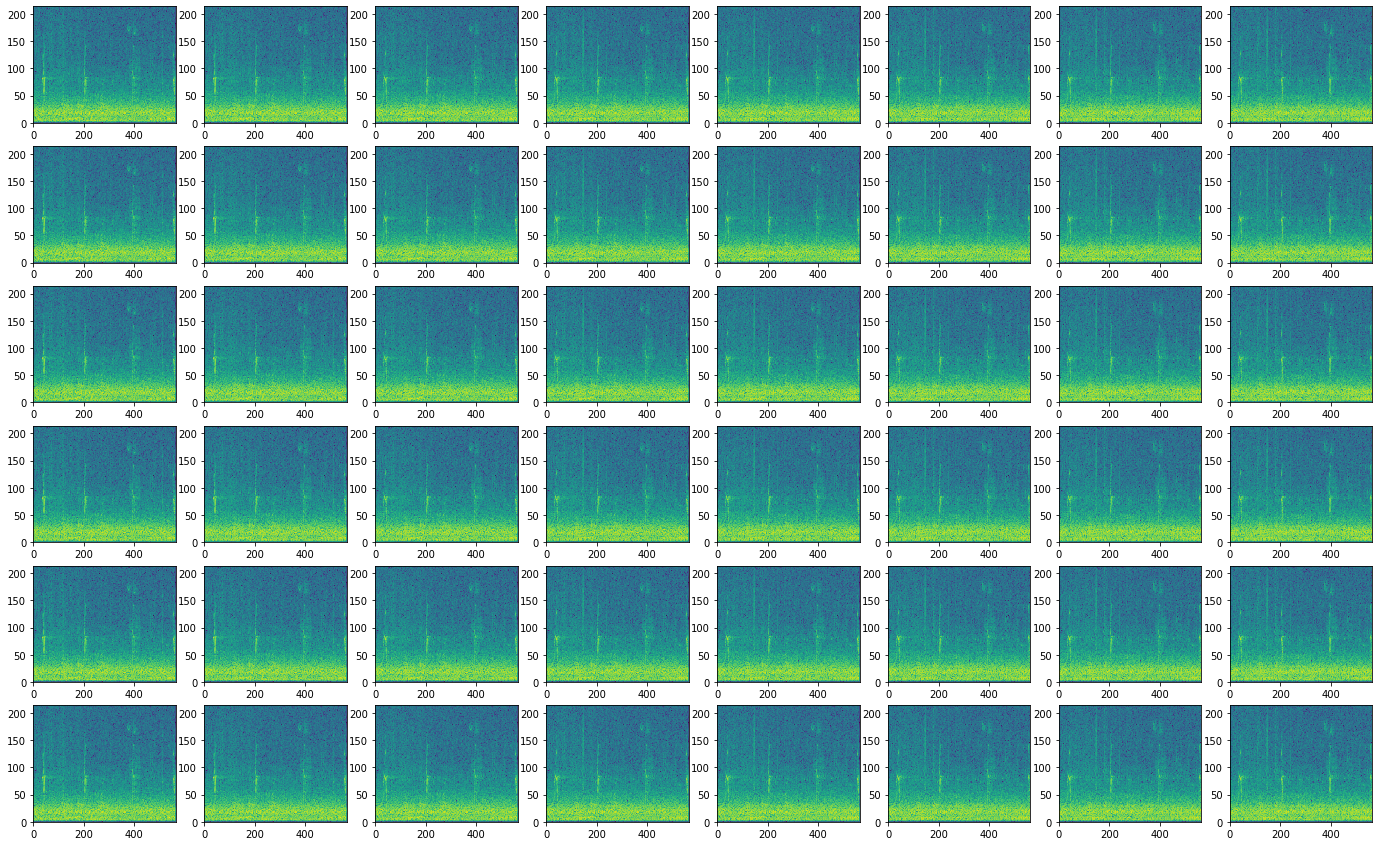

In [ ]:
overall_outputs, overall_errors, distances_meters = experimentSNR(num_azim = num_azim)

In [ ]:
distances = [5, 10, 15, 20, 25, 30, 35, 40] # this is in yards
[dist * 0.9144 for dist in distances]

[4.572, 9.144, 13.716, 18.288, 22.86, 27.432, 32.004, 36.576]

In [ ]:
overall_errors

{'AIM (t-f)': array([[  5.5,   7.5,   5.5,   4.5,   6.5,   5.5,   4.5, 158.5],
        [  9.5,   7.5,   5.5,   2.5,   6.5,   5.5,   4.5, 155.5],
        [  1.5,   6.5,   6.5,  15.5,   7.5,   4.5,   1.5, 156.5],
        [  6.5,   9.5,   7.5,   4.5,   5.5,   6.5,   2.5, 166.5],
        [  1.5,   7.5,   6.5,   3.5,   6.5,   4.5,   1.5, 162.5],
        [  8.5,   5.5,   6.5,   7.5,   6.5,   5.5,   9.5, 167.5]]),
 'AIM (time)': array([[  5.5,   9.5,  12.5,   8.5,  16.5,  24.5,   7.5, 164.5],
        [  8.5,   7.5,   7.5,   6.5,   4.5,  14.5,   0.5, 165.5],
        [  6.5,  16.5,  12.5,  10.5,  10.5,  13.5,  40.5, 154.5],
        [  9.5,   5.5,   9.5,   7.5,  13.5,  15.5, 178.5, 142.5],
        [  5.5,  15.5,  18.5,  23.5,  18.5,   4.5, 149.5, 144.5],
        [  7.5,  10.5,  11.5,  10.5,  18.5,  15.5, 158.5, 166.5]]),
 'MUSIC (t-f)': array([[  5.5,  10.5,  16.5,  15.5,   7.5,  21.5,  63.5, 142.5],
        [  7.5,   8.5,  10.5,  29.5,   6.5,  12.5,  29.5, 146.5],
        [  5.5,  13.5,  15.5, 

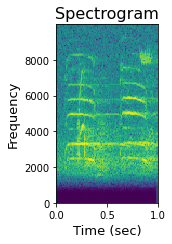

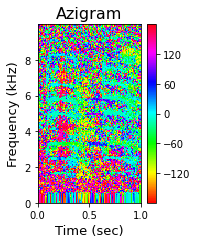

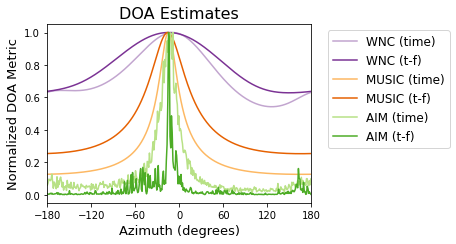

In [ ]:
output = plotSingleDistanceTrial(trial = 7, call = 4, num_azim = num_azim, highpass_filter = 2000, SAVEFIG=True)

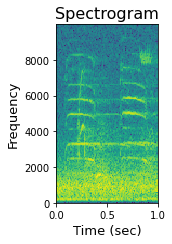

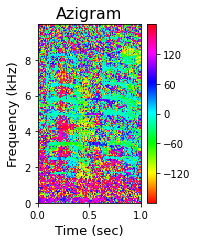

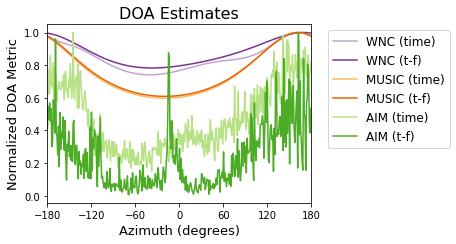

In [ ]:
output = plotSingleDistanceTrial(trial = 7, call = 4, num_azim = num_azim, highpass_filter = 200, SAVEFIG=True)

{'WNC (time)': array([ 18.3,  13.7,  13.1, 106.7,  16.7,  17.1, 131.1, 154.7]), 'WNC (t-f)': array([  1.9,   7.3,   8.9,  42.3,   5.5,   4.3, 129.3, 158.3]), 'MUSIC (time)': array([  6.7,  11.3,  12.7,  35.5,  10.3,   7.7,  88.9, 149.1]), 'MUSIC (t-f)': array([  6.7,  11.7,  13.1,  36.7,  10.7,   8.3,  89.3, 149.3]), 'AIM (time)': array([  7.5,  11.1,  11.9,  11.7,  13.1,  12.7, 105.5, 154.7]), 'AIM (t-f)': array([  5.5,   7.3,   6.5,   6.7,   6.5,   5.3,   3.9, 161.7])}
{'WNC (time)': array([ 0.74833148,  2.92574777,  3.00665928, 77.02051675,  1.93907194,
        2.24499443, 51.64726517,  7.4939976 ]), 'WNC (t-f)': array([ 1.2       ,  2.99332591,  3.38230691, 59.92461931,  2.60768096,
        2.4       , 55.39458457,  7.02566723]), 'MUSIC (time)': array([ 0.9797959 ,  2.13541565,  2.4       , 22.30694959,  2.71293199,
        4.53431362, 29.70925782,  7.88923317]), 'MUSIC (t-f)': array([ 0.9797959 ,  2.56124969,  2.41660919, 23.24994624,  2.63818119,
        4.66476152, 30.32754524, 

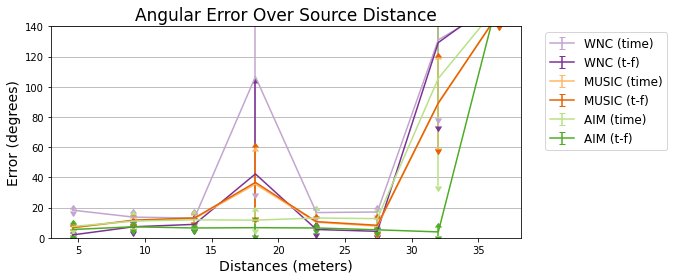

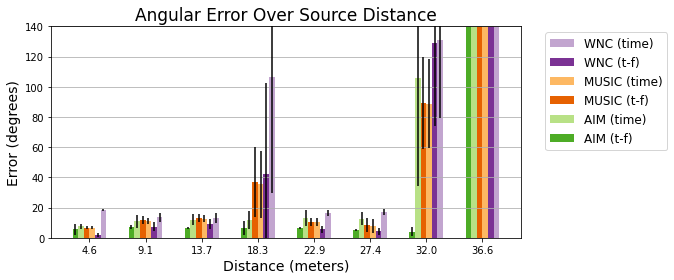

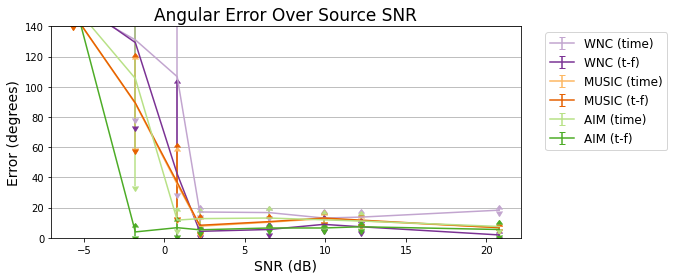

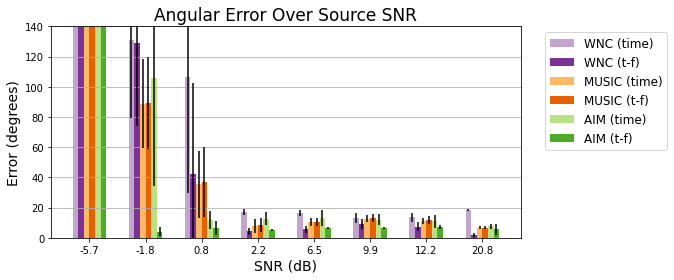

In [ ]:
makeDistanceLinePlot(overall_errors, distances_meters, [0, 140], SAVE_FILENAME = '_hz_07_11_2022')
#SAVE_FILENAME = '_' + str(highpass_filter) + 'hz_04_15_2022_v2'

## Two sources

In [ ]:
separation_angles = [0, 5.625, 11.25, 22.5, 45]

# start times for '07_11_2021_two_speaker_experiment_lwhs'
start_times = [33.02, 80.45, 128.08, 174.54, 220.45]
end_times = [67.26, 114.66, 162.28, 208.83, 254.69]
file = '07_11_2021_two_speaker_experiment_lwhs'

signal_duration = 1 #34.097

# DOA estimation parameters
azim_edges = np.linspace(-180, 180, num_azim + 1)
azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2


signal, framerate = loadWav(file, folder)

overall_outputs = []
overall_diffs = {}

reference_maxima = None

for trial in range(len(start_times)):
    print('---- ' + str(separation_angles[trial]) + ' ----')
    specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[trial]+1,
                                               end_time = start_times[trial]+1 + signal_duration,
                                               nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)

    specs_B_ni, s_B_ni, inds_B_ni, freqs_B_ni = loadSignal(signal, framerate, start_time=start_times[trial] - 1,
                                                           end_time = start_times[trial], nf = nf, n_fft=n_fft,
                                                           highpass_filter=highpass_filter)

    specs_B_flat_ni = np.array([spec.ravel() for spec in specs_B_ni])

    # run all current methods and return a huge output dictionary
    output = runAllMethods(s_B, specs_B, num_azim, num_alti, s_B_ni = s_B_ni, specs_B_flat_ni = specs_B_flat_ni, music_sources = 2, wnc_param = wnc_param)

    # get maxima of angles corresponding to this output?
    maxima = getOutputMaximaAll(output)

    # get accuracy corresponding to this output?
    diffs = getAngularDistanceBetweenTwoSources(maxima, azims)

    # put all results in overall structure
    overall_outputs.append(output)

    # calculate covariance
    covariance = specs_B.ravel()) @ (specs_B.ravel()).T

    # calculate eigenvalues of covariance
    [eigvals, eigvecs] = np.linalg.eig(covariance)

    # if the dictionary doesn't exist yet, initialize it
    if (len(overall_diffs) == 0):
        for key in diffs:
            overall_diffs[key] = np.zeros((len(start_times)))

    # place angular error in correct place in main output dictionary
    for key in diffs:
        overall_diffs[key][trial] = diffs[key]

Streaming output truncated to the last 5000 lines.
MUSSIC eigenvalues:  [13.77193417+5.37254435e-16j  0.97160652-7.04757483e-17j
  0.22785663+5.36930622e-18j  0.09886603-7.24210110e-18j]
MUSSIC eigenvalues:  [13.77193417+5.37254435e-16j  0.97160652-7.04757483e-17j
  0.22785663+5.36930622e-18j  0.09886603-7.24210110e-18j]
MUSSIC eigenvalues:  [13.77193417+5.37254435e-16j  0.97160652-7.04757483e-17j
  0.22785663+5.36930622e-18j  0.09886603-7.24210110e-18j]
MUSSIC eigenvalues:  [13.77193417+5.37254435e-16j  0.97160652-7.04757483e-17j
  0.22785663+5.36930622e-18j  0.09886603-7.24210110e-18j]
MUSSIC eigenvalues:  [13.77193417+5.37254435e-16j  0.97160652-7.04757483e-17j
  0.22785663+5.36930622e-18j  0.09886603-7.24210110e-18j]
MUSSIC eigenvalues:  [13.77193417+5.37254435e-16j  0.97160652-7.04757483e-17j
  0.22785663+5.36930622e-18j  0.09886603-7.24210110e-18j]
MUSSIC eigenvalues:  [13.77193417+5.37254435e-16j  0.97160652-7.04757483e-17j
  0.22785663+5.36930622e-18j  0.09886603-7.24210110e-18

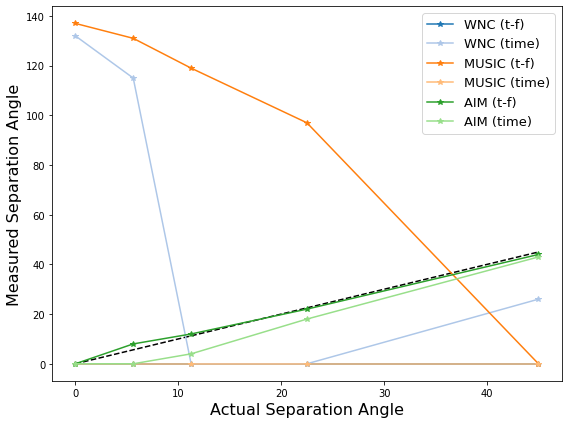

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.plot(separation_angles, separation_angles, 'k--')
for method in overall_diffs:
    plt.plot(separation_angles, overall_diffs[method], '*-', label=method)

plt.xlabel('Actual Separation Angle', fontsize=16)
plt.ylabel('Measured Separation Angle', fontsize=16)
plt.legend(fontsize=13)
fig.tight_layout()

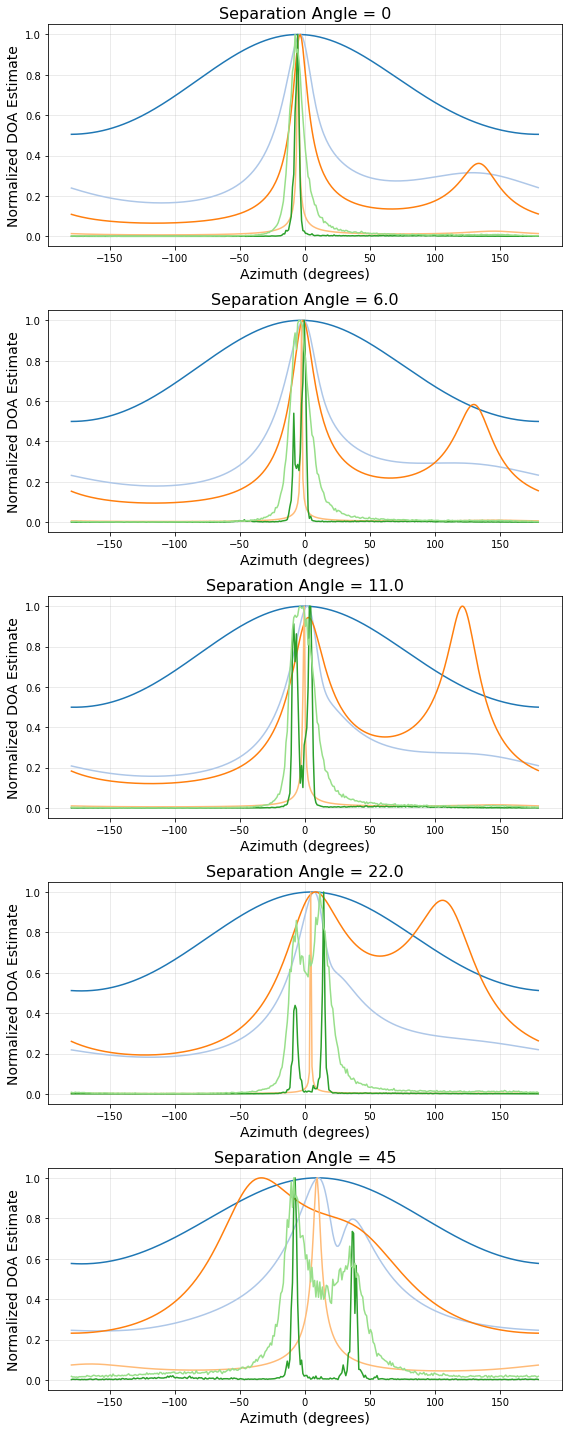

In [ ]:
fig_output, ax_output = plt.subplots(5, 1, figsize=(8, 20))
for trial in range(len(start_times)):
    ax_output[trial].grid(True, alpha=0.3)
    for method in output:
        ax_output[trial].plot(azims, overall_outputs[trial][method], label=method)
        ax_output[trial].set_xlabel('Azimuth (degrees)', fontsize=14)
        ax_output[trial].set_ylabel('Normalized DOA Estimate', fontsize=14)
        ax_output[trial].set_title('Separation Angle = ' + str(np.round(separation_angles[trial])), fontsize=16)

fig_output.tight_layout()
#fig_output.savefig(figures_folder + 'two_sources_' + str(highpass_filter) + 'hz.png', dpi=200)

In [ ]:
file = '07_11_2021_two_speaker_experiment_lwhs'
signal, framerate = loadWav(file, folder)

In [ ]:
def plotTwoSourceTrial(trial = 2, num_azim = num_azim, SAVEFIG = None):
    full_note_duration = 2#5

    separation_angles = [0, 5.625, 11.25, 22.5, 45]
    start_times = [33.02, 80.45, 128.08, 174.54, 220.45]
    end_times = [67.26, 114.66, 162.28, 208.83, 254.69]

    # DOA estimation parameters
    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    specs_B_ni, s_B_ni, inds_B_ni, freqs_B_ni = loadSignal(signal, framerate, start_time=10,
                                                              end_time = 16, nf = nf, n_fft=n_fft,
                                                              highpass_filter=highpass_filter)

    specs_B_flat_ni = np.array([spec.ravel() for spec in specs_B_ni])


    specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[trial] + 1.3,
                                              end_time = start_times[trial] + full_note_duration + 1.3,
                                              nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)

    # run all current methods and return a huge output dictionary
    output = runAllMethods(s_B, specs_B, num_azim, num_alti = 0, s_B_ni = s_B_ni, specs_B_flat_ni = specs_B_flat_ni, music_sources = 2, wnc_param = wnc_param)

    fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
    plt.pcolormesh(inds_B, freqs_B/1000, logTransform(np.abs(specs_B[0].T)), linewidth=0, rasterized=True)
    ax.set_title('Spectrogram', fontsize=16)
    #ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
    ax.set_xlabel('Time (sec)', fontsize=13)
    ax.set_ylabel('Frequency (kHz)', fontsize=13)
    #plt.colorbar()
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('two_source_example_real_spec' + SAVEFIG + '.png', dpi=200)
            fig.savefig('two_source_example_real_spec' + SAVEFIG + '.pdf', dpi=200)

    wcaim = WCAIM()
    wcaim.scan(specs_B, num_azim)

    fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
    plt.pcolormesh(inds_B, freqs_B/1000, wcaim.azimuth.T * 180/np.pi, cmap='hsv',
                   linewidth=0, rasterized=True, vmin=-180, vmax=180)
    ax.set_title('Azigram', fontsize=16)
    ax.set_xlabel('Time (sec)', fontsize=13)
    ax.set_ylabel('Frequency (kHz)', fontsize=13)
    #plt.colorbar(ticks = [-180, -120, -60, 0, 60, 120, 180])
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('two_source_example_real_azim' + SAVEFIG + '.png', dpi=200)
            fig.savefig('two_source_example_real_azim' + SAVEFIG + '.pdf', dpi=200)

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
    for method in output:
        ax.plot(azims, output[method], label=method)
        #ax_output.legend(loc='upper left', fontsize=12)
        ax.set_xlabel('Azimuth (degrees)', fontsize=13)
        ax.set_ylabel('Normalized DOA Metric', fontsize=13)
        ax.set_title('DOA Estimate', fontsize=16)
        ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
        ax.set_xlim([-180, 180])

    ax.plot([-6, -6], [0, 1], 'k--')
    ax.plot([separation_angles[trial] - 6, separation_angles[trial] - 6], [0, 1], 'k--')

    #ax.legend(loc='upper left', fontsize=12)
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('two_source_example_real_dist' + SAVEFIG + '.png', dpi=200)
            fig.savefig('two_source_example_real_dist' + SAVEFIG + '.pdf', dpi=200)

In [ ]:
def plotTwoSourceTime(start_time, duration, num_azim = num_azim, SAVEFIG = None):

    # DOA estimation parameters
    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    specs_B_ni, s_B_ni, inds_B_ni, freqs_B_ni = loadSignal(signal, framerate, start_time = 10,
                                                              end_time = 16, nf = nf, n_fft=n_fft,
                                                              highpass_filter=highpass_filter)

    specs_B_flat_ni = np.array([spec.ravel() for spec in specs_B_ni])


    specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time = start_time,
                                              end_time = start_time + duration,
                                              nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)

    # run all current methods and return a huge output dictionary
    output = runAllMethods(s_B, specs_B, num_azim, num_alti = 0, s_B_ni = s_B_ni, specs_B_flat_ni = specs_B_flat_ni, music_sources = 2, wnc_param = wnc_param)

    fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
    plt.pcolormesh(inds_B, freqs_B/1000, logTransform(np.abs(specs_B[0].T)), linewidth=0, rasterized=True)
    ax.set_title('Spectrogram', fontsize=16)
    #ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
    ax.set_xlabel('Time (sec)', fontsize=13)
    ax.set_ylabel('Frequency (kHz)', fontsize=13)
    #plt.colorbar()
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('two_source_example_real_spec' + SAVEFIG + '.png', dpi=200)
            fig.savefig('two_source_example_real_spec' + SAVEFIG + '.pdf', dpi=200)

    wcaim = WCAIM()
    wcaim.scan(specs_B, num_azim)

    fig, ax = plt.subplots(1, 1, figsize=(2.3, 3.5))
    plt.pcolormesh(inds_B, freqs_B/1000, wcaim.azimuth.T * 180/np.pi, cmap='hsv',
                   linewidth=0, rasterized=True, vmin=-180, vmax=180)
    ax.set_title('Azigram', fontsize=16)
    ax.set_xlabel('Time (sec)', fontsize=13)
    ax.set_ylabel('Frequency (kHz)', fontsize=13)
    #plt.colorbar(ticks = [-180, -120, -60, 0, 60, 120, 180])
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('two_source_example_real_azim' + SAVEFIG + '.png', dpi=200)
            fig.savefig('two_source_example_real_azim' + SAVEFIG + '.pdf', dpi=200)

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
    for method in output:
        ax.plot(azims, output[method], label=method)
        #ax_output.legend(loc='upper left', fontsize=12)

    ax.set_xlabel('Azimuth (degrees)', fontsize=13)
    ax.set_ylabel('Normalized DOA Metric', fontsize=13)
    ax.set_title('DOA Estimate', fontsize=16)
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
    ax.set_xlim([-180, 180])

    ax.plot([-6, -6], [0, 1], 'k--')
    #ax.plot([separation_angles[trial] - 6, separation_angles[trial] - 6], [0, 1], 'k--')

    #ax.legend(loc='upper left', fontsize=12)
    fig.tight_layout()
    if (SAVEFIG):
            fig.savefig('two_source_example_real_dist' + SAVEFIG + '.png', dpi=200)
            fig.savefig('two_source_example_real_dist' + SAVEFIG + '.pdf', dpi=200)

    return output

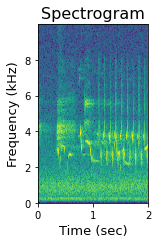

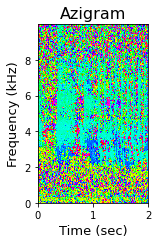

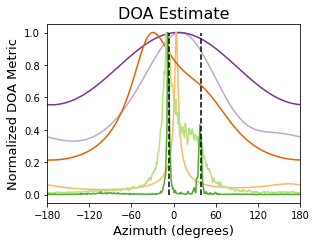

In [ ]:
plotTwoSourceTrial(trial = 4, num_azim = num_azim, SAVEFIG='_04_29_2022')

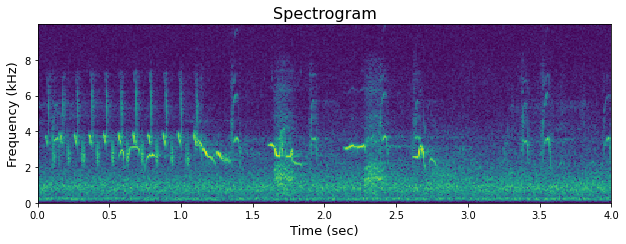

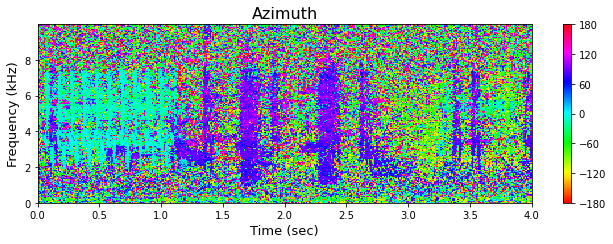

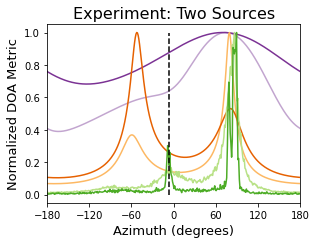

In [ ]:
output = plotTwoSourceTime(start_time = 18 * 60 + 26, duration = 4, num_azim = num_azim)

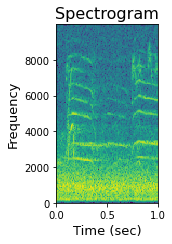

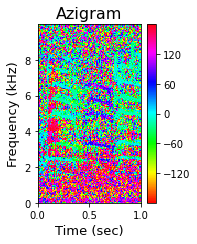

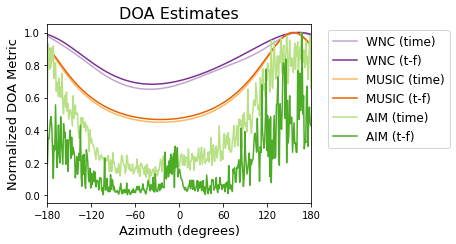

In [ ]:
output = plotSingleDistanceTrial(trial = 7, call = 5, num_azim = num_azim)

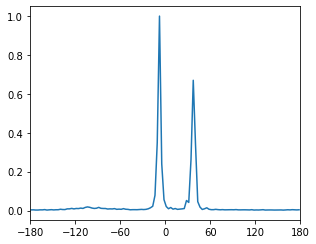

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
ax.plot(azims, overall_outputs[trial]['AIM (t-f)'], label=method)
    #ax.plot([true_angles[trial], true_angles[trial]], [0, 1], 'k--')
    #ax_output.legend(loc='upper left', fontsize=12)
    #ax.set_xlabel('Azimuth (degrees)', fontsize=13)
    #ax.set_ylabel('DOA Distribution', fontsize=13)
    #ax.set_title(r'Real Data: Source at %d$\degree$' % (true_angles[trial]), fontsize=16)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
ax.set_xlim([-180, 180])

#ax.legend(loc='upper left', fontsize=12)
fig.tight_layout()

In [ ]:
def fitAngularGMMWithOptimalClustersSimple(points, K_min=1, K_max=8, bic_threshold=0.05, PLOT=True, SAVEFIG=False):
    N = points.size
    scores_silh = []
    scores_aic = []
    scores_bic = []

    #if (PLOT):
    #    plt.figure(figsize=(4, 2.5*(K_max - K_min + 1)))

    pyplot_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = pyplot_colors

    all_likelihoods = {}
    all_mixture_means = {}
    all_mixture_covs = {}
    all_mixture_weights = {}
    all_member_weights = {}

    Ks = np.arange(K_min, K_max+1)

    for K in Ks:
        print("\nCluster number = ", K)

        start_time = time.time()

        [mixture_means, mixture_covs, mixture_weights, member_weights, mixture_means_list, mixture_covs_list] = \
                    fitGaussianMixtureModel(points, K = K, max_iterations = 200, tolerance = 0.005, \
                    warm_start_means = None, warm_start_covs = None, warm_start_weights = None)

        end_time = time.time()

        # get some metrics for this trial
        point_probs = calculateAllProbabilities(points, mixture_means, mixture_covs, K, N)
        all_likelihoods[K] = logLikelihood(point_probs, mixture_weights, K, N)

        if (K > 1):
            mixture_heights = []
            for k in range(K):
                mixture_heights.append(mixture_weights[k] * calculateProbability(mixture_means[k], mixture_covs[k], mixture_means[k]))

            # store in sorted order
            new_order = np.argsort(mixture_heights)[::-1]
            all_mixture_means[K] = mixture_means[new_order]
            all_mixture_covs[K] = mixture_covs[new_order]
            all_mixture_weights[K] = mixture_weights[new_order]
            all_member_weights[K] = member_weights[new_order,:]
        else:
            all_mixture_means[K] = mixture_means
            all_mixture_covs[K] = mixture_covs
            all_mixture_weights[K] = mixture_weights
            all_member_weights[K] = member_weights

        # print info about this trial
        print('GMM fit took: %.2f sec. Log likelihood = %.2f.' % (end_time - start_time, all_likelihoods[K]))

        # calculate scores
        #scores_silh.append(silhouetteScore(points, best_member_weights))
        scores_aic.append(aic(all_likelihoods[K], K))
        scores_bic.append(bic(all_likelihoods[K], K, N))

        # plot histogram with overlayed distributions
        if (PLOT):
            curves = []
            plt.figure(figsize=(4, 7.5))
            plt.subplot(K_max - K_min + 1, 1, K - K_min + 1)
            plt.hist(points, bins=num_azim, density=True, alpha=0.5)
            for k in range(K):
                curve = np.zeros((num_azim))
                for i in range(num_azim):
                    curve[i] = all_mixture_weights[K][k] * calculateProbability(all_mixture_means[K][k], all_mixture_covs[K][k], azims[i])
                plt.plot(azims, curve, color=colors[-k], label='Component %d' % k)
                curves.append(curve)
            plt.plot(azims, np.sum(np.array(curves), axis=0), 'k--', label='Sum of Gaussians')
            plt.title('GMM with K = %d' % K, fontsize=16)
            plt.tight_layout()

            if (SAVEFIG):
                plt.savefig(figures_folder + SAVEFIG + '_fit.png')
                plt.savefig(figures_folder + SAVEFIG + '_fit.pdf')

    # normalized the cluster scores
    scores_aic = np.array(scores_aic/np.max(scores_aic))
    scores_bic = np.array(scores_bic/np.max(scores_bic))
    scores_bic = np.array(scores_bic/np.max(scores_bic))
    #scores_silh = np.array(scores_silh/np.max(scores_silh))

    best_K_mask = (scores_bic - np.min(scores_bic) < bic_threshold)
    print(best_K_mask)
    best_K = Ks[np.nonzero(best_K_mask)[0][0]]
    print(best_K)

    if (PLOT):
        plt.figure(figsize=(4, 3))
        #plt.plot(Ks, scores_silh, label='Silhouette Scores')
        plt.plot(Ks, scores_aic, label='AIC Scores')
        plt.plot(Ks, scores_bic, label='BIC Scores')
        plt.title('Scores Across Clusters (Normalized): best is %d' % best_K)
        plt.xlabel('Cluster number K')
        plt.ylabel('Score')
        plt.legend()

    if (PLOT and SAVEFIG):
        plt.tight_layout()
        plt.savefig(figures_folder + SAVEFIG + '_bic.png', dpi=200)
        plt.savefig(figures_folder + SAVEFIG + '_bic.pdf', dpi=200)

    # plot histogram with overlayed distributions for best_K
    if (PLOT):
        curves = []
        plt.figure()
        plt.hist(points, bins=num_azim, density=True, alpha=0.5)
        for k in range(best_K):
            curve = np.zeros((num_azim))
            for i in range(num_azim):
                curve[i] = all_mixture_weights[best_K][k] * calculateProbability(all_mixture_means[best_K][k], all_mixture_covs[best_K][k], azims[i])
            plt.plot(azims, curve, label='Component %d' % k)
            curves.append(curve)
        plt.plot(azims, np.sum(np.array(curves), axis=0), 'k--', label='Sum of Gaussians')
        plt.title('Best Fit! K = %d' % best_K)
        plt.legend()

    if (PLOT and SAVEFIG):
        plt.tight_layout()
        #plt.savefig(figures_folder + SAVEFIG + '_best.png', dpi=200)
        #plt.savefig(figures_folder + SAVEFIG + '_best.pdf', dpi=200)

    return best_K, all_mixture_means[best_K], all_mixture_covs[best_K], all_mixture_weights[best_K], all_member_weights[best_K]

In [ ]:
estims = output['AIM (t-f)']


#### Example with noisy data

In [ ]:
!pip install import-ipynb
import import_ipynb

from gmm_angular_1D import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00
importing Jupyter notebook from gmm_angular_1D.ipynb


In [ ]:
def runTwoSourceTrialAIM(trial, num_azim = num_azim):
    full_note_duration = 5

    separation_angles = [0, 5.625, 11.25, 22.5, 45]
    start_times = [33.02, 80.45, 128.08, 174.54, 220.45]
    end_times = [67.26, 114.66, 162.28, 208.83, 254.69]

    # DOA estimation parameters
    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    # load in WAV file
    file = '07_11_2021_two_speaker_experiment_lwhs'
    signal, framerate = loadWav(file, folder)

    # calculate spectrograms
    specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[trial] + 0.5,
                                              end_time = start_times[trial] + full_note_duration + 0.5,
                                              nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)

    # do DOA estimation
    aim_tf = WCAIM()
    output = aim_tf.scan(specs_B, num_azim)
    phis = aim_tf.azimuth

    # now load in original corresponding signal
    specs_ground_truth, s_ground_truth, inds, freqs = loadSignalMono('04_09_2021_two_speakers_ground_truth.wav',
                                                     start_time = 1.4, end_time = 1.4 + full_note_duration,
                                                     n_fft = n_fft, nf = nf, highpass_filter = highpass_filter)


    return specs_B, s_B, framerate, inds_B, freqs_B, output, phis, azims, specs_ground_truth, s_ground_truth

In [ ]:
def runDistanceTrialAIM(trial, call, num_azim=360):
    # load in recordings of a particular trial and call of the distance experiment:
    file = '07_11_2021_distance_experiment_lwhs'
    full_note_duration = 1 #0.3
    true_angles = np.array([0, 60, 120, -180, -120, -60])
    start_times = [20.60, 38.61, 56.11, 81.97, 101.96, 126.34, 146.27, 165.38]
    call_times = [0, 1.5, 3.24, 4.78, 6.66, 8.16] #[0, 0.54, 1.51, 2.15, 3.33, 3.87, 4.83, 5.50, 6.75, 7.29, 8.25, 8.90]

    # DOA estimation parameters
    azim_edges = np.linspace(-180, 180, num_azim + 1)
    azims = azim_edges[0:-1] + (azim_edges[1] - azim_edges[0])/2

    # load in WAV file
    signal, framerate = loadWav(file, folder)

    # calculate spectrograms
    specs_B, s_B, inds_B, freqs_B = loadSignal(signal, framerate, start_time=start_times[trial] + call_times[call],
                                                      end_time = start_times[trial] + call_times[call] + full_note_duration,
                                                      nf = nf, n_fft=n_fft, highpass_filter=highpass_filter)
    # do DOA estimation
    aim_tf = WCAIM()
    output = aim_tf.scan(specs_B, num_azim)
    phis = aim_tf.azimuth

    # now load in original corresponding signal
    specs_ground_truth, s_ground_truth, inds, freqs = loadSignalMono('blue_jay_short_audio.mp3',
                                                     #start_time = 1.9, end_time = 1.9 + full_note_duration,
                                                     start_time = 0.4, end_time = 0.4 + full_note_duration,
                                                     n_fft = n_fft, nf = nf, highpass_filter = highpass_filter)

    # return a lot of components
    return specs_B, s_B, framerate, inds_B, freqs_B, output, phis, azims, specs_ground_truth, s_ground_truth

In [ ]:
def angleThresholding(specs, estimate, azims, K, width = 5, buffer = 10, SAVEFIG=False):
    # maybe slightly smooth out estimate??
    maxima = getBufferedMaxima(estimate, buffer)
    K = np.min([K - 1, len(maxima)])

    gmm_styles = ['solid', 'dashed', 'dotted', 'dashdot']

    plt.figure(figsize=(5, 3.5))
    #counts, _, _, = plt.hist(180/np.pi * sample_points, bins=len(azims), density=True, alpha=0.5, color='grey')
    #plt.plot(azims, estimate, color=colors[5])
    plt.fill_between(azims, 0, estimate, color=colors[5], alpha=0.5)
    for k in range(K):
        #plt.plot([azims[maxima[k]], azims[maxima[k]]], [0, 1], 'k--', alpha=0.5, color=gmm_colors[k])
        minus = np.mod((azims[maxima[k]] - width + 180), 360) - 180
        plus = np.mod((azims[maxima[k]] + width + 180), 360) - 180
        plt.plot([minus, minus], [0, 1], 'k--', alpha=1, color='k', linestyle=gmm_styles[k])
        plt.plot([plus, plus], [0, 1], 'k--', alpha=1, color='k', linestyle=gmm_styles[k])

    plt.title('Angular Thresholding with K = %d' % (K+1), fontsize=16)
    plt.xlabel('Azimuth (degrees)', fontsize=13)
    plt.ylabel('Normalized DOA Metric', fontsize=13)
    plt.xlim([-180, 180])
    plt.ylim([0, 1])
    plt.tight_layout()
    if (SAVEFIG):
        plt.savefig('source_separation_%s_threshold.pdf' % DEMO, dpi=200)

    reconstructions = []
    background = specs[0].copy()

    # make a range around the maxima
    for k in range(K):
        mask = (angleErrorDegrees(180/np.pi * phis, azims[maxima[k]]) > width)
        reconstruction = specs[0].copy()
        reconstruction[mask] = 0
        reconstructions.append(reconstruction)
        background[~mask] = 0

    reconstructions.append(background)
    print('Difference between reconstruction sum and original spectrogram: ', np.mean(np.abs(np.sum(reconstructions, axis=0) - specs[0])))
    return reconstructions

In [ ]:
def gmmFit(specs, estimate, azims, K, SAVEFIG=False):
    sample_points = np.random.choice(azims * np.pi/180, size=10000, p = estimate/np.sum(estimate))

    [mixture_means, mixture_covs, mixture_weights, member_weights, mixture_means_list, mixture_covs_list] = \
                        fitGaussianMixtureModel(sample_points, K = K, max_iterations = 500, tolerance = 0.005, \
                        warm_start_means = None, warm_start_covs = None, warm_start_weights = None)

    gmm_styles = ['solid', 'dashed', 'dotted', 'dashdot', (0, (5, 1))]

    gmm_azims = np.linspace(-np.pi, np.pi, 100)

    curves = []

    plt.figure(figsize=(5, 3.5))
    plt.hist(180/np.pi * sample_points, bins=len(azims), density=True, alpha=0.5, color=colors[5])
    for k in range(K):
        curve = np.zeros((len(gmm_azims)))
        for i in range(len(gmm_azims)):
            curve[i] = np.pi/180 * mixture_weights[k] * calculateProbability(mixture_means[k], mixture_covs[k], gmm_azims[i])
        plt.plot(180/np.pi * gmm_azims, curve, color='k', linestyle=gmm_styles[k], label='Component %d' % k)
        curves.append(curve)
    #plt.plot(180/np.pi * gmm_azims, np.sum(np.array(curves), axis=0), 'k--', label='Sum of Gaussians')
    plt.title('Gaussian Mixture Model with K = %d' % K, fontsize=16)
    plt.xlabel('Azimuth (degrees)', fontsize=13)
    plt.ylabel('Normalized DOA Metric', fontsize=13)
    plt.xlim([-180, 180])
    if (DEMO == 'noisy'):
        plt.ylim([0, 0.015])
    else:
        plt.ylim([0, 0.09])

    plt.tight_layout()
    if (SAVEFIG):
        plt.savefig('source_separation_%s_gmm.pdf' % DEMO, dpi=200)

    # get pressure spectrogram
    nx, nf = specs[0].shape

    # calculate predictions and member weights for all pixels and for this GMM fit
    predictions = calculateAllProbabilities(phis.ravel(), mixture_means, mixture_covs, K, nx * nf)
    mixture_weights_new, member_weights_new, Nks_new = calculateMixtureMemberWeights(predictions, mixture_weights, K, predictions.shape[1])

    # reconstruct individual sources by scaling the intensities by the member weights
    reconstructions = []

    # calculate reconstructions
    for ind in range(K):
        temp = member_weights_new[ind,:] * specs[0].ravel()
        reconstructions.append(temp.reshape(nx, nf))

    ordering = np.argsort([np.sum(np.abs(x)) for x in reconstructions])[::-1]
    reconstructions = [reconstructions[o] for o in ordering]

    print('Difference between reconstruction sum and original spectrogram: ', np.mean(np.abs(np.sum(reconstructions, axis=0) - specs[0])))

    return reconstructions, mixture_means, mixture_covs, mixture_weights_new, member_weights_new

#### Actually run this example!

In [ ]:
nf_full = 513

In [ ]:
DEMO = 'clean_feb2023'

In [ ]:
if (DEMO == 'noisy'):
    K = 4
    specs, s, framerate, inds, freqs, aim_output, phis, azims, specs_ground_truth, s_ground_truth = \
      runDistanceTrialAIM(trial = 6, call = 2, num_azim = num_azim)
    specs_ground_truth = [specs_ground_truth[0]]
else:
    K = 3
    specs, s, framerate, inds, freqs, aim_output, phis, azims, specs_ground_truth, s_ground_truth = runTwoSourceTrialAIM(trial = 4, num_azim = num_azim)

In [ ]:
# visualize original signals
# plt.figure(figsize=(len(specs) * 2.5, 3.5))
# for ind in range(len(specs)):
#     plt.subplot(1, len(specs), ind+1)
#     plt.pcolormesh(inds, freqs/1000, logTransform(np.abs(specs[ind])).T, vmax = -15, vmin = -100, linewidth=0, rasterized=True)
#     #plt.colorbar()
#     #plt.title('Reconstruction of Component ' + str(ind), fontsize=14)
#     plt.xlabel('Time (sec)', fontsize=13)
#     if (ind == 0):
#         plt.ylabel('Frequency (kHz)', fontsize=13)

# plt.tight_layout()

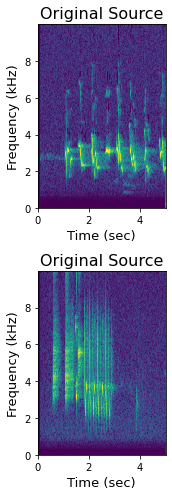

In [ ]:
# visualize reconstructions!!
plt.figure(figsize=(2.5, len(specs_ground_truth) * 3.5))
for ind in range(len(specs_ground_truth)):
    plt.subplot(len(specs_ground_truth), 1, ind+1)
    plt.pcolormesh(inds, freqs/1000, logTransform(np.abs(specs_ground_truth[ind])).T, vmax = -15, vmin = -100, linewidth=0, rasterized=True)
    #plt.colorbar()
    plt.title('Original Source', fontsize=16)

    plt.xlabel('Time (sec)', fontsize=13)
    plt.ylabel('Frequency (kHz)', fontsize=13)

plt.tight_layout()
#plt.savefig('source_separation_%s_original_signal.pdf' % DEMO, dpi=200)

In [ ]:
specs_ground_truth[0].shape

(95, 214)

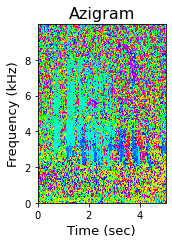

In [ ]:
# visualize original signals
plt.figure(figsize=(2.5, 3.5))
plt.pcolormesh(inds, freqs/1000, 180/np.pi * phis.T, cmap='hsv', vmin=-180, vmax=180, linewidth=0, rasterized=True)
plt.title('Azigram', fontsize=16)
plt.xlabel('Time (sec)', fontsize=13)
plt.ylabel('Frequency (kHz)', fontsize=13)
plt.tight_layout()
#plt.savefig('source_separation_%s_azigram.pdf' % DEMO, dpi=200)

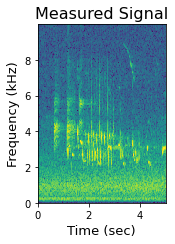

In [ ]:
# visualize original signals
plt.figure(figsize=(2.5, 3.5))
plt.pcolormesh(inds, freqs/1000, logTransform(np.abs(specs[0])).T, vmax = -15, vmin = -100, linewidth=0, rasterized=True)
plt.title('Measured Signal', fontsize=16)
plt.xlabel('Time (sec)', fontsize=13)
plt.ylabel('Frequency (kHz)', fontsize=13)
plt.tight_layout()
#plt.savefig('source_separation_%s_measured_signal.pdf' % DEMO, dpi=200)

Difference between reconstruction sum and original spectrogram:  1.313242059043688e-19


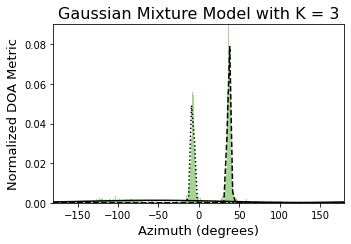

In [ ]:
## --- reconstructions with GMM --- ##
np.random.seed(20)
reconstructions_gmm, mixture_means, mixture_covs, mixture_weights, member_weights = \
    gmmFit(specs=specs, estimate=aim_output, azims=azims, K = K, SAVEFIG=True)

Difference between reconstruction sum and original spectrogram:  0.0


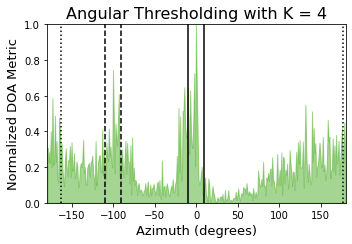

In [ ]:
## --- reconstructions with angular thresholding --- ##
reconstructions_ang = angleThresholding(specs, aim_output, azims, K, width = 10, buffer = 20, SAVEFIG=True)

NameError: ignored

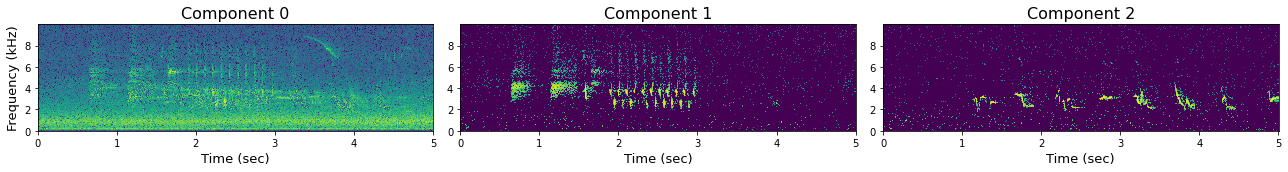

In [ ]:
if (DEMO == 'noisy'):
    plot_width = 2.0
else:
    #plot_width = 2.5 (ussed in paper)
    plot_width = 6 # (for graphics)

# visualize reconstructions!!
plt.figure(figsize=(K * plot_width, 2.5))
for ind in range(K):
    plt.subplot(1, K, ind+1)
    plt.pcolormesh(inds, freqs/1000, logTransform(np.abs(reconstructions_gmm[ind])).T,
                   vmax = -15, vmin = -100, linewidth=0, rasterized=True)
    #plt.colorbar()
    plt.title('Component ' + str(ind), fontsize=16)
    plt.xlabel('Time (sec)', fontsize=13)
    if (ind == 0):
        plt.ylabel('Frequency (kHz)', fontsize=13)

plt.tight_layout()
plt.savefig('source_separation_%s_recon_gmm_signal.png' % DEMO, dpi=200)

# visualize reconstructions!!
order = [3, 1, 0, 2]
plt.figure(figsize=(len(reconstructions_ang) * plot_width, 3.5))
for ind in range(len(reconstructions_ang)):
    plt.subplot(1, len(reconstructions_ang), ind+1)
    plt.pcolormesh(inds, freqs/1000, logTransform(np.abs(reconstructions_ang[order[ind]])).T, vmax = -15, vmin = -100, linewidth=0, rasterized=True)
    #plt.colorbar()
    plt.title('Component ' + str(ind), fontsize=16)
    plt.xlabel('Time (sec)', fontsize=13)
    if (ind == 0):
        plt.ylabel('Frequency (kHz)', fontsize=13)

plt.tight_layout()
plt.savefig('source_separation_%s_recon_ang_signal.pdf' % DEMO, dpi=200)

In [ ]:
def timeDomainReconstruction(reconstructions, nf_full):
    reconstructions_time = []
    for k in range(len(reconstructions)):
        spec = np.zeros((reconstructions[k].shape[0], nf_full), dtype=complex)
        spec[:, 0:nf] = reconstructions[k]
        t, x = scipysig.istft(spec.T, fs=framerate, nperseg=n_fft)
        reconstructions_time.append(x)

    ordering = np.argsort([np.sum(np.abs(x)) for x in reconstructions_time])[::-1]
    reconstructions_time = [reconstructions_time[o] for o in ordering]
    return reconstructions_time

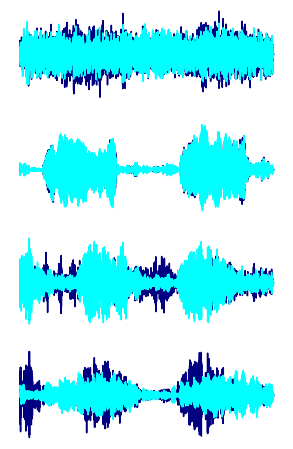

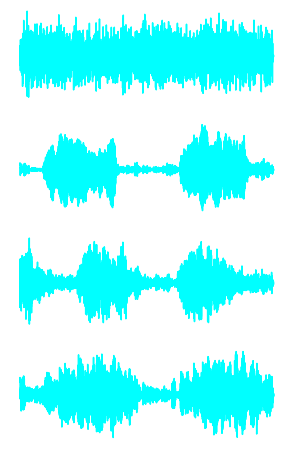

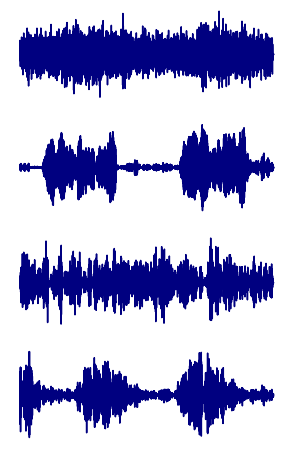

In [ ]:
reconstructions_gmm_time = timeDomainReconstruction(reconstructions_gmm, nf_full)
reconstructions_ang_time = timeDomainReconstruction(reconstructions_ang, nf_full)

plt.figure(figsize=(5, len(reconstructions_gmm) * 2))
for k in range(len(reconstructions_gmm)):
    plt.subplot(len(reconstructions_gmm), 1, k+1)
    plt.plot(reconstructions_ang_time[k], color='navy')
    plt.plot(reconstructions_gmm_time[k], color='cyan')
    plt.axis('off')

plt.figure(figsize=(5, len(reconstructions_gmm) * 2))
plt.title('GMM')
for k in range(len(reconstructions_gmm)):
    plt.subplot(len(reconstructions_gmm), 1, k+1)
    plt.plot(reconstructions_gmm_time[k], color='cyan')
    plt.axis('off')

plt.figure(figsize=(5, len(reconstructions_ang) * 2))
plt.title('Angular Thresholding')
for k in range(len(reconstructions_ang)):
    plt.subplot(len(reconstructions_ang), 1, k+1)
    plt.plot(reconstructions_ang_time[k], color='navy')
    plt.axis('off')

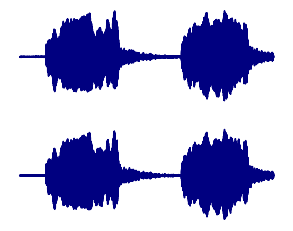

In [ ]:
plt.figure(figsize=(5, 4))
for g in range(2):
    plt.subplot(2, 1, g+1)
    plt.plot(s_ground_truth[g], color='navy')
    plt.axis('off')

[[  0.         481.68438824  29.65806861 148.2591302 ]
 [  0.         480.91621357  30.02345828 148.5824524 ]]
[[  0.         324.02609762   6.17801262  13.21951389]
 [  0.         323.49070926   6.39427127  13.42118666]]


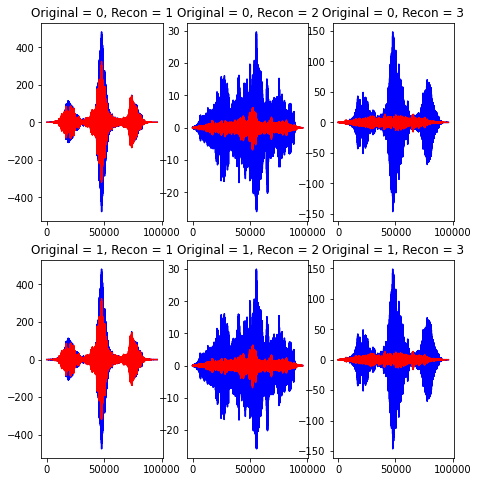

In [ ]:
# run crosscorrelation!
corr_gmm = np.zeros((2, K))
corr_ang = np.zeros((2, K))

plt.figure(figsize=(10, 8))
for g in range(2):
    for k in range(1, K):

        corr_gmm_full = scipysig.correlate(reconstructions_gmm_time[k], s_ground_truth[g], mode='full')
        corr_ang_full = scipysig.correlate(reconstructions_ang_time[k], s_ground_truth[g], mode='full')

        corr_gmm[g, k] = np.max(corr_gmm_full)
        corr_ang[g, k] = np.max(corr_ang_full)

        plt.subplot(2, K, K * g + k + 1)
        plt.plot(corr_gmm_full, color='b', label='gmm')
        plt.plot(corr_ang_full, color='r', label='ang')
        plt.title('Original = %d, Recon = %d' % (g, k))

print(corr_gmm)
print(corr_ang)

In [ ]:
481.68438824/324.02609762

1.486560470832485

In [ ]:
corr_ang[1, 2]/corr_gmm[1, 2]

1.2624360923006912

IndexError: ignored

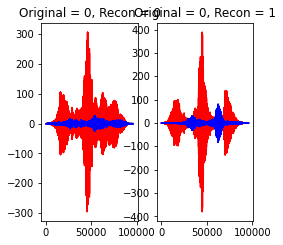

In [ ]:
# run crosscorrelation!
corr_gmm = np.zeros((2, 2))
corr_ang = np.zeros((2, 2))

plt.figure(figsize=(10, 8))
for g in range(1):
    for k in range(K):

        corr_gmm_full = scipysig.correlate(reconstructions_gmm_time[k], s_ground_truth[g], mode='full')
        corr_ang_full = scipysig.correlate(reconstructions_ang_time[k], s_ground_truth[g], mode='full')

        corr_gmm[g, k] = np.max(corr_gmm_full)
        corr_ang[g, k] = np.max(corr_ang_full)

        plt.subplot(2, K, 2 * g + k + 1)
        plt.plot(corr_ang_full, color='r', label='ang')
        plt.plot(corr_gmm_full, color='b', label='gmm')
        plt.title('Original = %d, Recon = %d' % (g, k))

print(corr_gmm)
print(corr_ang)

In [ ]:
# next steps:
#   - repeat wiith the noisy signal case?
#   - convert to time domain (done!)
#   - do cross-correlation analysis (done!)

In [ ]:
# notes on current work:
# make equivalent of "background" component! (done!)

In [ ]:
reconstructions_gmm_time = timeDomainReconstruction(reconstructions_gmm, nf_full)

In [ ]:
len(reconstructions_gmm_time[0])/framerate

5.002666666666666

In [ ]:
def makeAudioReconstruction(spec, nf_full, framerate, highpass_filter):
    (nx, nf) = spec.shape
    spec_full = np.zeros((nx, nf_full), dtype=np.complex_)
    spec_full[:, 0:nf] = spec
    t, audio = scipysig.istft(spec_full.T, framerate)
    audio = butter_highpass_filter(audio, highpass_filter, framerate)
    audio = audio.astype(np.float32)
    return audio

In [ ]:
for ind in range(K):
    test = makeAudioReconstruction(reconstructions_gmm[0], nf_full, framerate, highpass_filter)
    display(Audio(s, rate=framerate))